# Imports

In [1]:
import os 

import dagshub
import mlflow

from mlflow.models.signature import infer_signature

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso

# Set some options...
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

cwd = os.getcwd()

for dirname, _, filenames in os.walk(f'{cwd}/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

train_df = pd.read_csv(f'{cwd}/input/train.csv')
test_df = pd.read_csv(f'{cwd}/input/test.csv')

/Users/davitdadiani/Desktop/git/House-Prices-ML/input/test.csv
/Users/davitdadiani/Desktop/git/House-Prices-ML/input/data_description.txt
/Users/davitdadiani/Desktop/git/House-Prices-ML/input/clean_test.csv
/Users/davitdadiani/Desktop/git/House-Prices-ML/input/train.csv
/Users/davitdadiani/Desktop/git/House-Prices-ML/input/sample_submission.csv


# Some usefull functions

In [2]:
def plot_univariate(df, feature, bins=20):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], bins=bins, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

def plot_bivariate(df, feature1, feature2):
    plt.figure(figsize=(10, 6))
    if df[feature1].dtype in ['float64', 'int64'] and df[feature2].dtype in ['float64', 'int64']:
        sns.scatterplot(x=df[feature1], y=df[feature2])
        plt.title(f'Relationship between {feature1} and {feature2}')
        plt.xlabel(feature1)
        plt.ylabel(feature2)
    else:
        sns.boxplot(x=df[feature1], y=df[feature2])
        plt.title(f'Box plot of {feature2} by {feature1}')
        plt.xlabel(feature1)
        plt.ylabel(feature2)
    
    plt.show()

def get_num_and_cat_features(df):
    num = [feature for feature in df.columns if df[feature].dtype != 'object']
    cat = [feature for feature in df.columns if df[feature].dtype == 'object']
  
    return (num, cat)

def get_numerical_features(df):
    return get_num_and_cat_features(df)[0]

def get_categorical_features(df):
    return get_num_and_cat_features(df)[1]
    

# Dataframe inspecting

In [3]:
train_df.shape

(1460, 81)

In [4]:
test_df.shape

(1459, 80)

We have information about 1460 houses in train dataframe and 1459 in test dataframe <br>
We have 81 columns in train_df and 80 in test_df, only thing which is missing in test_df is salessprice logically <br>
We can check info of each dataframe bellow... <br>

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

There is 36 numerical features (38 but with id, and salesprice) and 43 categorical features 

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

We have a lot of missing values in some features, for example we have only 91 non null value in "Alley" column <br>
let's try to print percentage of missing values bellow... <br> 

In [7]:
train_df_null_summary = train_df.isnull().sum().to_dict()

print(f"{'Feature':<20} {'Null Count':<12} {'Null %':<10}")
print("-" * 45)

for feature, null_count in train_df_null_summary.items():
    if null_count > 0:  
        null_percentage = null_count / len(train_df)
        print(f"{feature:<20} {null_count:<12} {null_percentage:<10.5f}")

Feature              Null Count   Null %    
---------------------------------------------
LotFrontage          259          0.17740   
Alley                1369         0.93767   
MasVnrType           872          0.59726   
MasVnrArea           8            0.00548   
BsmtQual             37           0.02534   
BsmtCond             37           0.02534   
BsmtExposure         38           0.02603   
BsmtFinType1         37           0.02534   
BsmtFinType2         38           0.02603   
Electrical           1            0.00068   
FireplaceQu          690          0.47260   
GarageType           81           0.05548   
GarageYrBlt          81           0.05548   
GarageFinish         81           0.05548   
GarageQual           81           0.05548   
GarageCond           81           0.05548   
PoolQC               1453         0.99521   
Fence                1179         0.80753   
MiscFeature          1406         0.96301   


After reviewing some rows and comparing related fields, I noticed that certain 'NaN' values are actually meaningful. For example the 'PoolArea' column contains no missing values but has several entries with a value of 0. <br> 
Whenever 'PoolArea' is 0 the corresponding 'PoolQC' value is always 'NaN'. This pattern suggests that 'NaN' in 'PoolQC' doesn't indicate missing data, but rather the absence of a pool. <br>

In [8]:
num, categ = get_num_and_cat_features(train_df)

train_df[num].describe().T.sort_values("std", ascending=False)

count           mean           std      min        25%  \
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
Id             1460.0     730.500000    421.610009      1.0     365.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   

                    50%        75%       max  
SalePrice      163000.0  214000.00  755000.0  
LotArea          9478.5   11601.50  215245.0  
GrLivArea        1464.0    1776.75    5642.0  
MiscVal             0.0       0.00   15500.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
2ndFlrSF            0.0     728.00    2065.0  
Id                730.5    1095.25    1460.0  
1stFlrSF         1087.0    1391.25    4692.0  
GarageArea        480.0     576.00    1418.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF2          0.0       0.00    1474.0  
WoodDeckSF          0.0     168.00     857.0  
OpenPorchSF        25.0      68.00     547.0  
EnclosedPorch       0.0       0.00     552.0  
ScreenPorch         0.0       0.00     480.0  
LowQualFinSF        0.0       0.00     572.0  
MSSubClass         50.0      70.00     190.0  
PoolArea            0.0       0.00     738.0  
YearBuilt        1973.0    2000.00    2010.0  
3SsnPorch           0.0       0.00     508.0  
GarageYrBlt      1980.0    2002.00    2010.0  
L

In [9]:
train_df[categ].describe()

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       1460         1460       1460       1460     1460       1460   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        1382          225       1260       1445     1220        726   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460        588      1460   
unique         6        8          15          16          3         4   
top        Gable  CompShg     VinylSd     VinylSd    BrkFace        TA   
freq        1141     1434         515         504        445       906   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       1460       1460     1423     1423         1422         1423   
unique         5          6        4        4            4            6   
top           TA      PConc       TA       TA           No          Unf   
freq        1282        647      649     1311          953          430   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          1422    1460      1460       1460       1459        1460   
unique            6       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           1256    1428       741       1365       1334         735   

       Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond  \
count        1460         770       1379         1379       1379       1379   
unique          7           5          6            3          5          5   
top           Typ          Gd     Attchd          Unf         TA         TA   
freq         1360         380        870          605       1311       1326   

       PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
count        1460      7    281          54     1460          1460  
unique          3      3      4           4        9             6  
top             Y     Gd  MnPrv        Shed       WD        Normal  
freq         1340      3    157          49     1267          1198

In [10]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

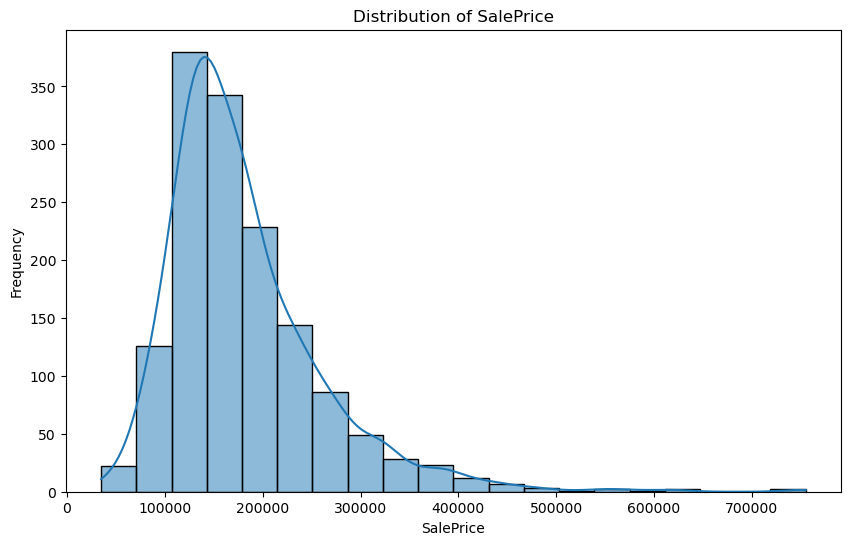

In [11]:
plot_univariate(train_df, 'SalePrice')

In [12]:
price_corr_matrix = train_df.corr(numeric_only=True)

# Get correlation of all numerical features with SalePrice, sorted
saleprice_corr = price_corr_matrix['SalePrice'].sort_values(ascending=False)

print(saleprice_corr)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

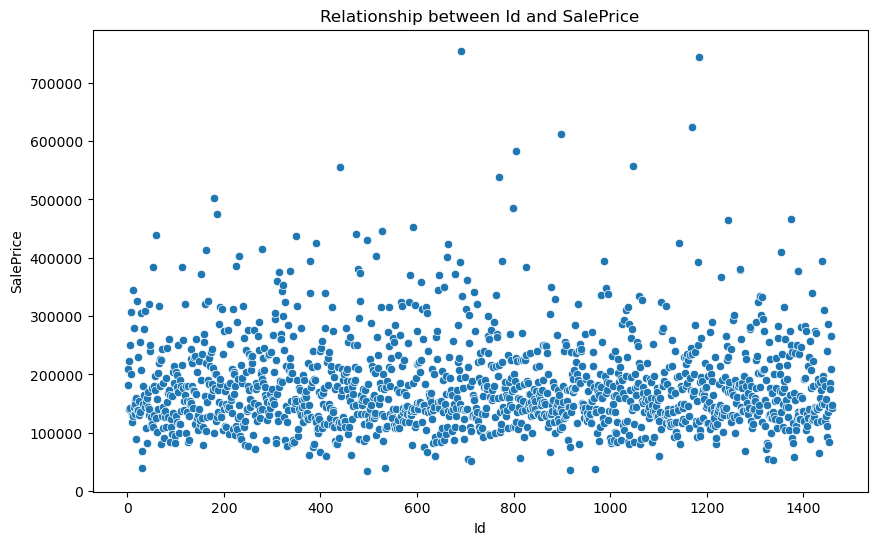

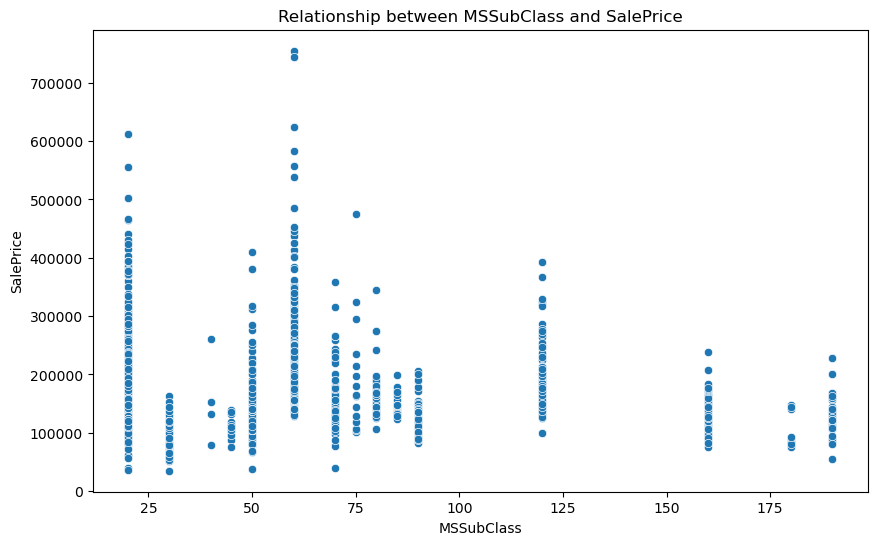

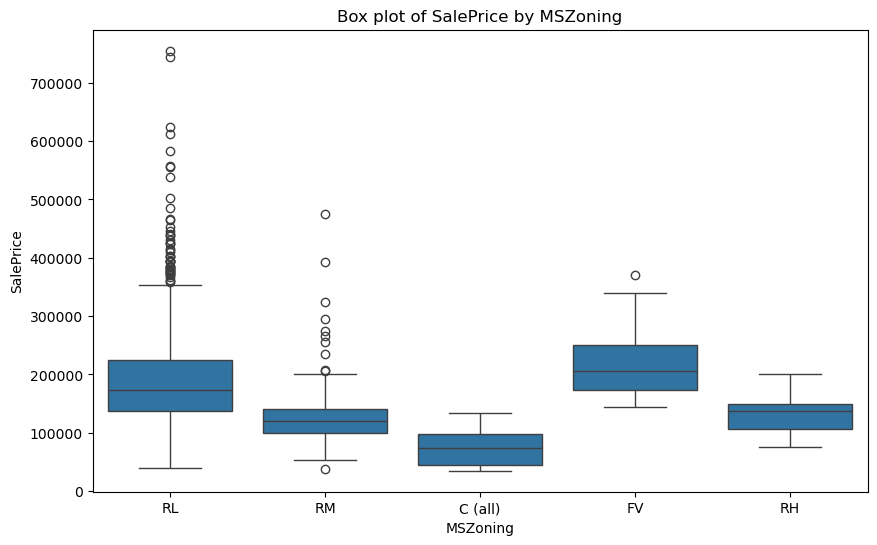

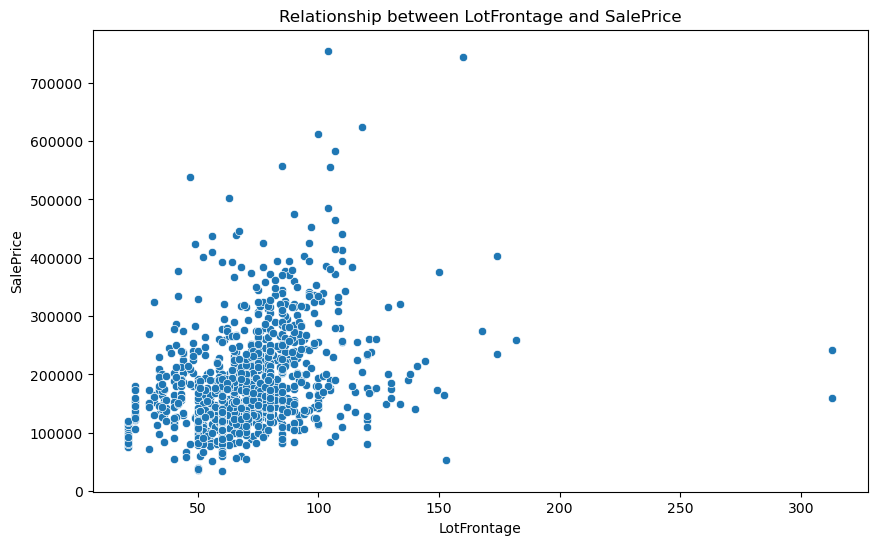

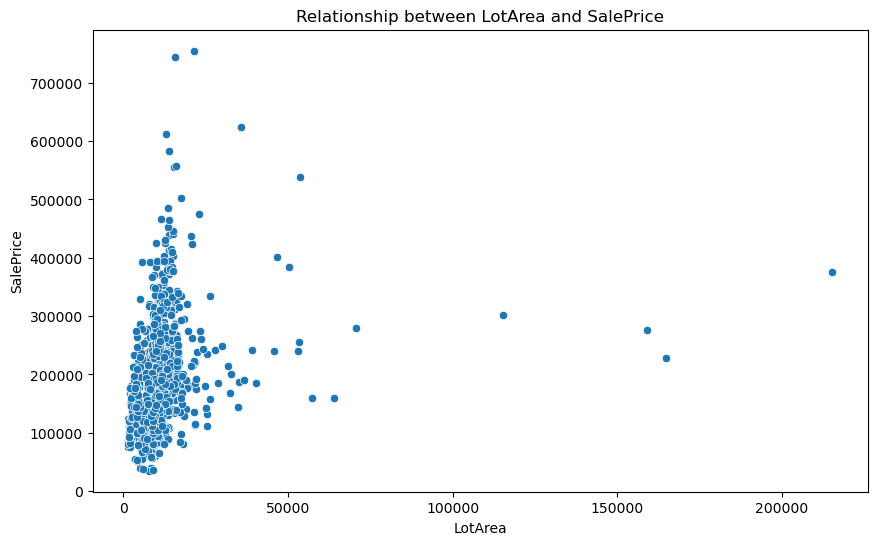

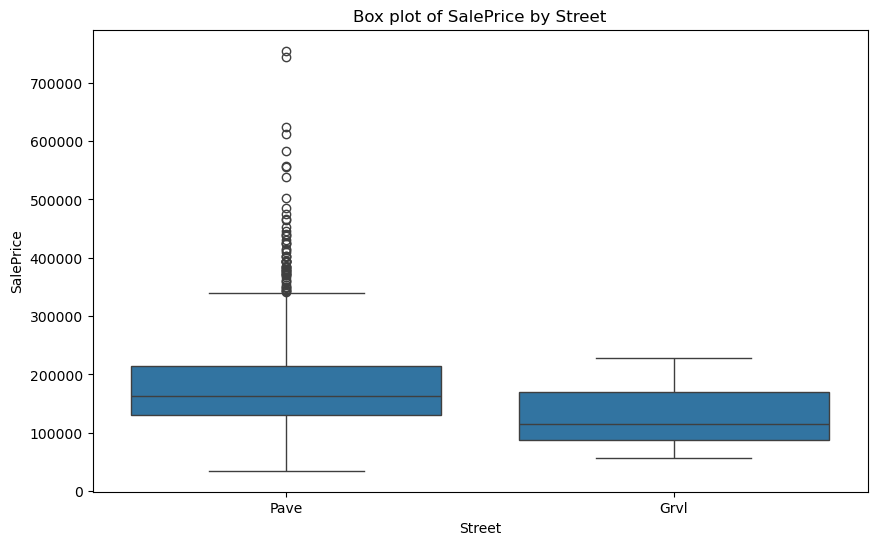

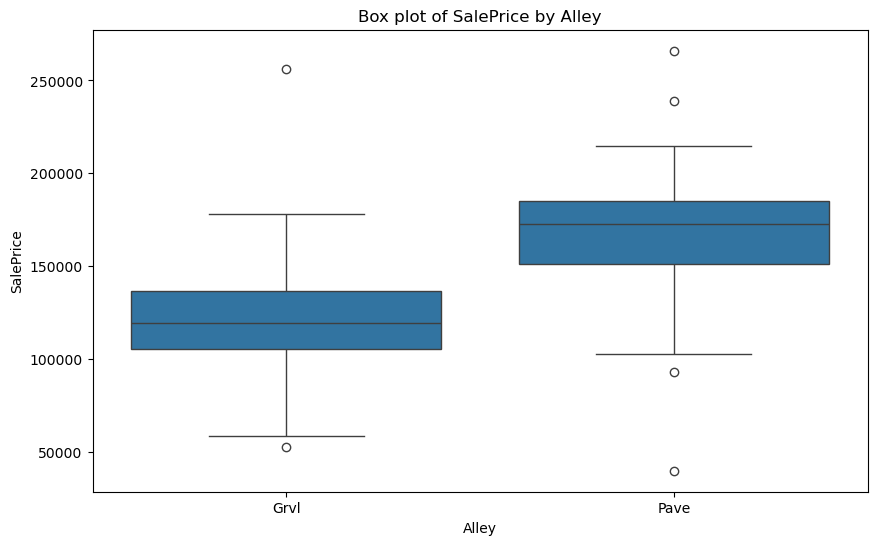

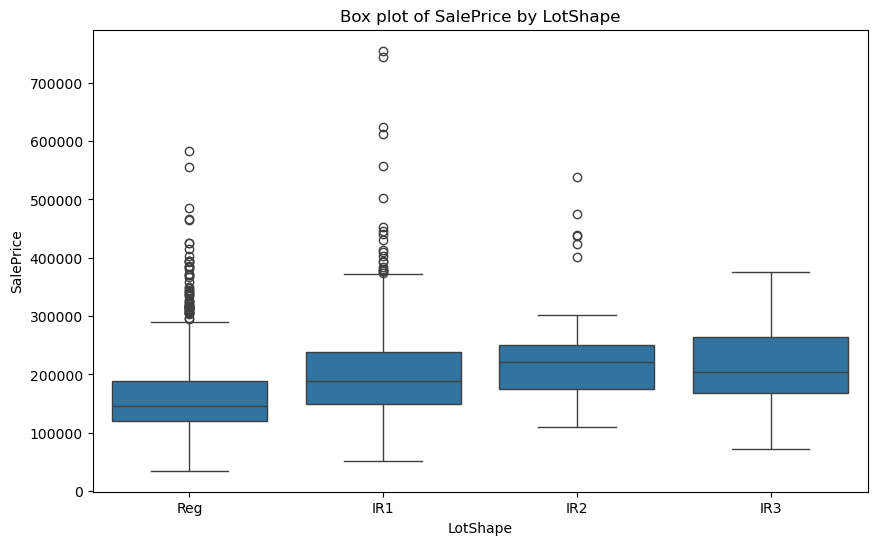

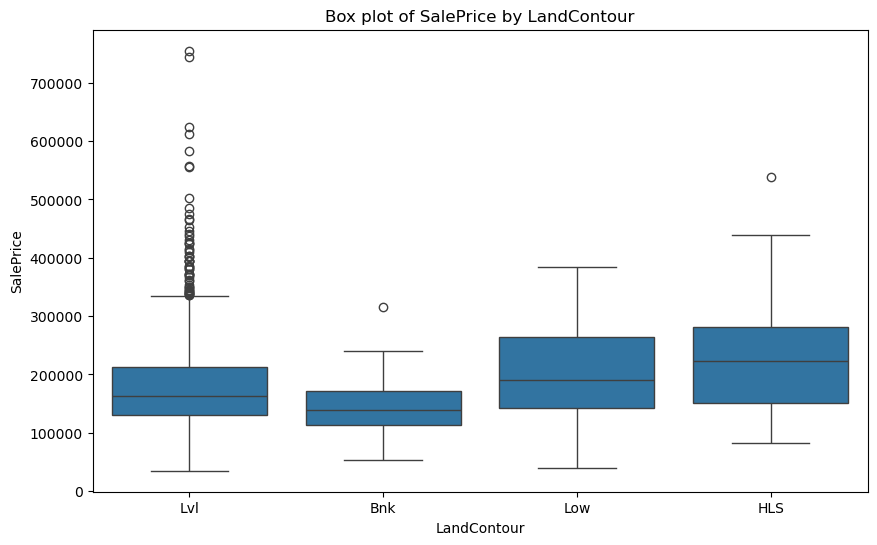

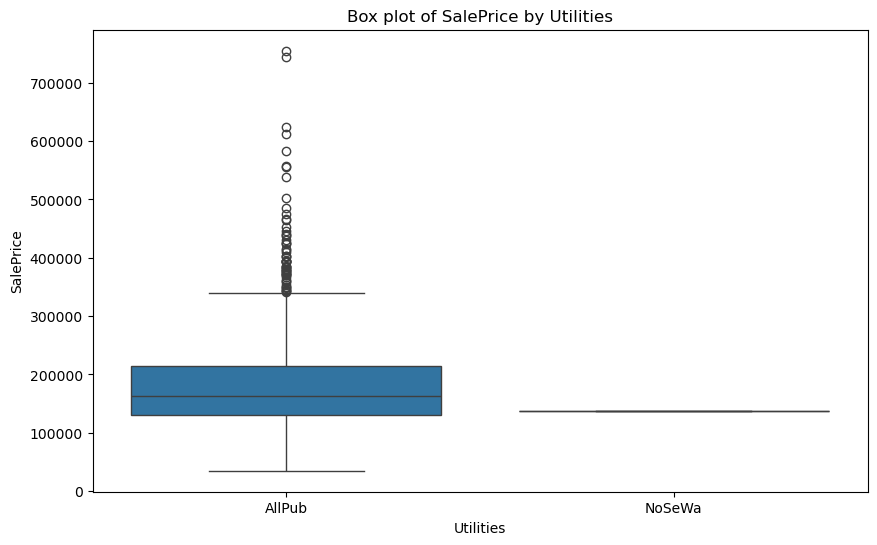

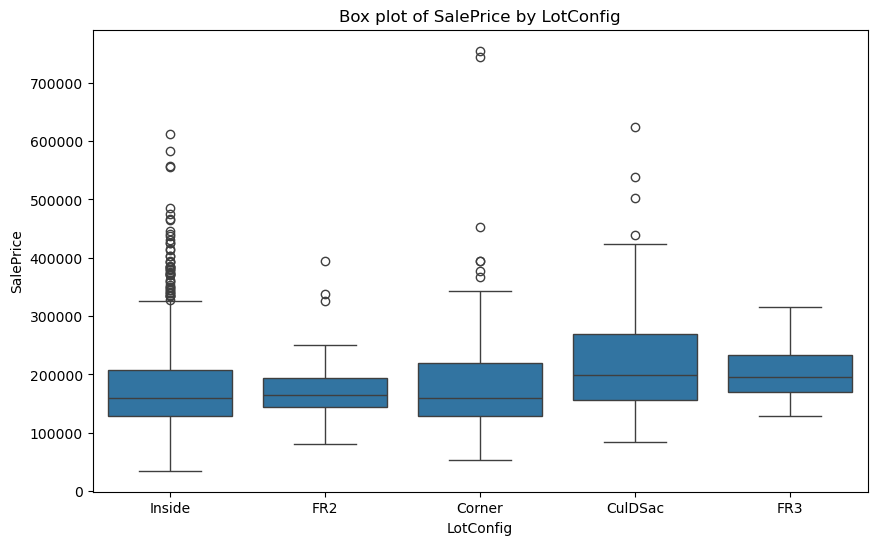

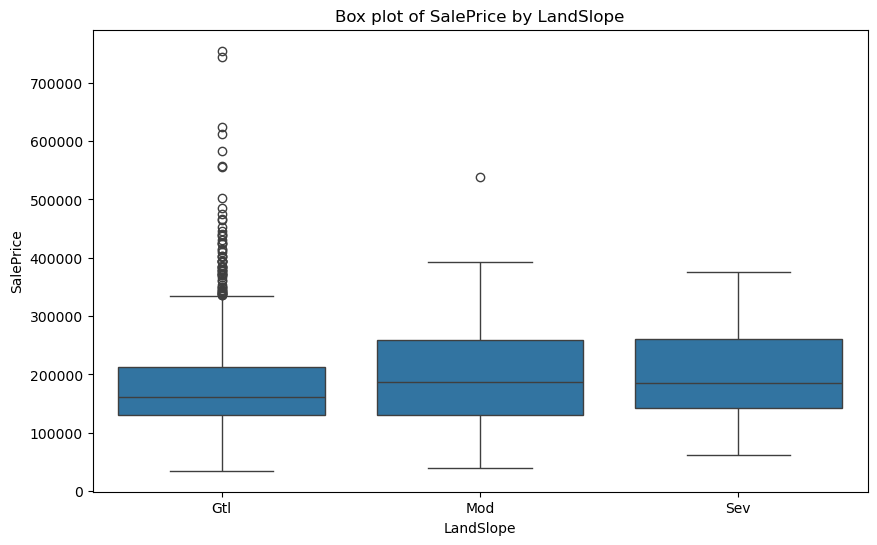

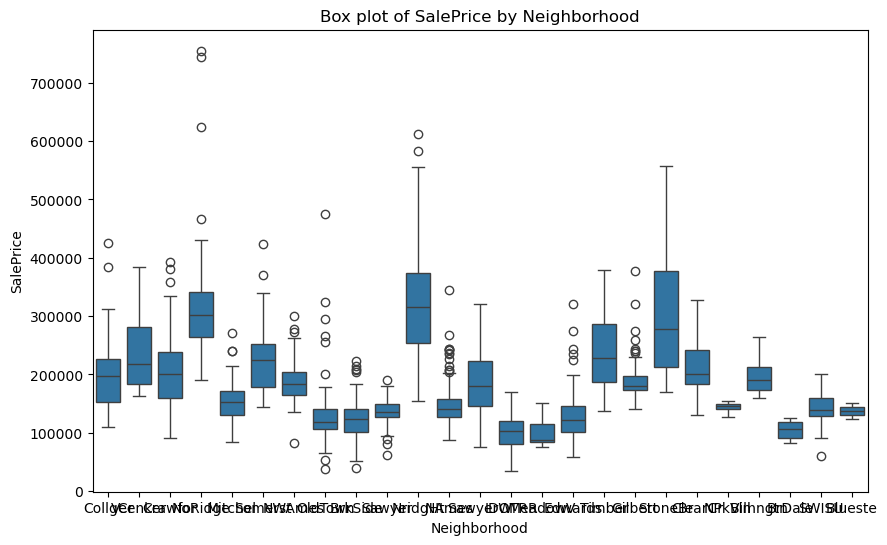

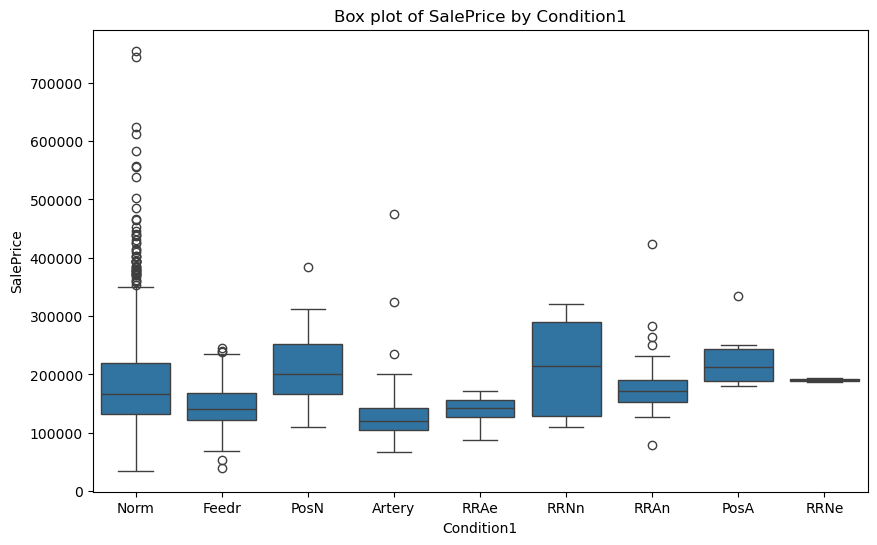

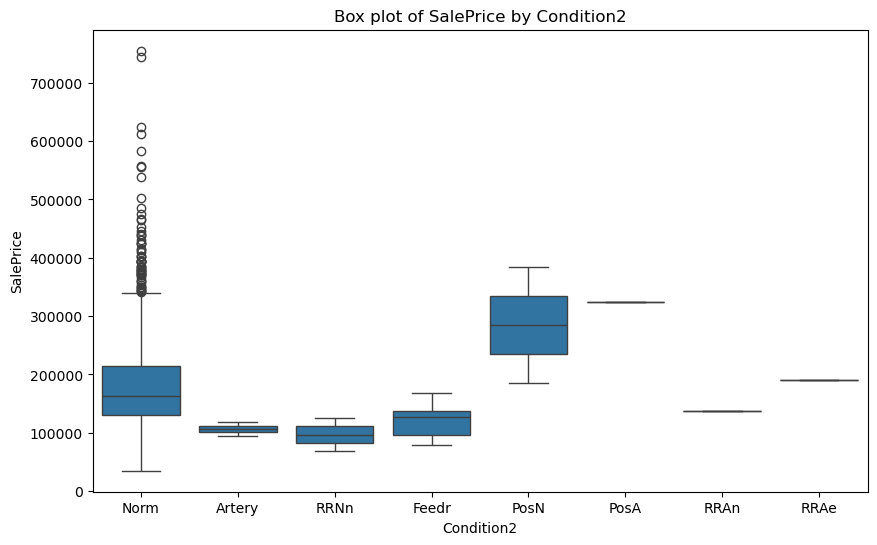

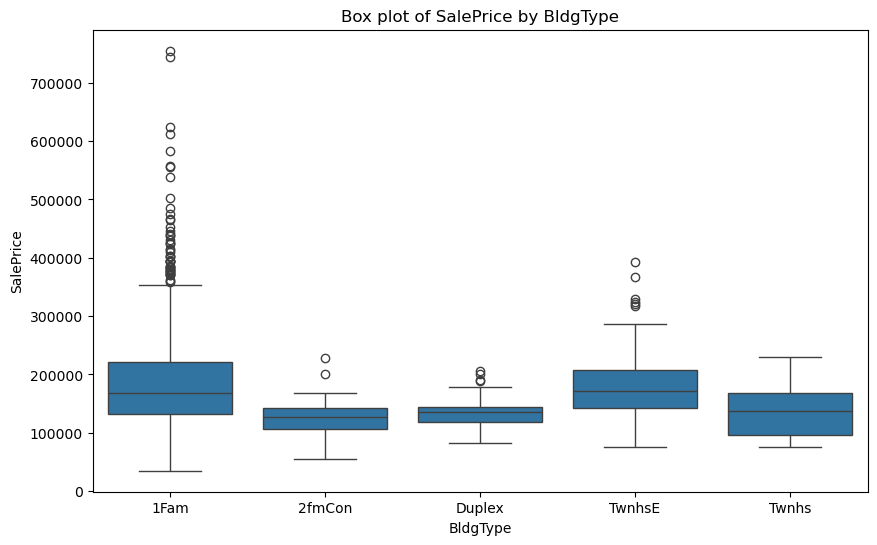

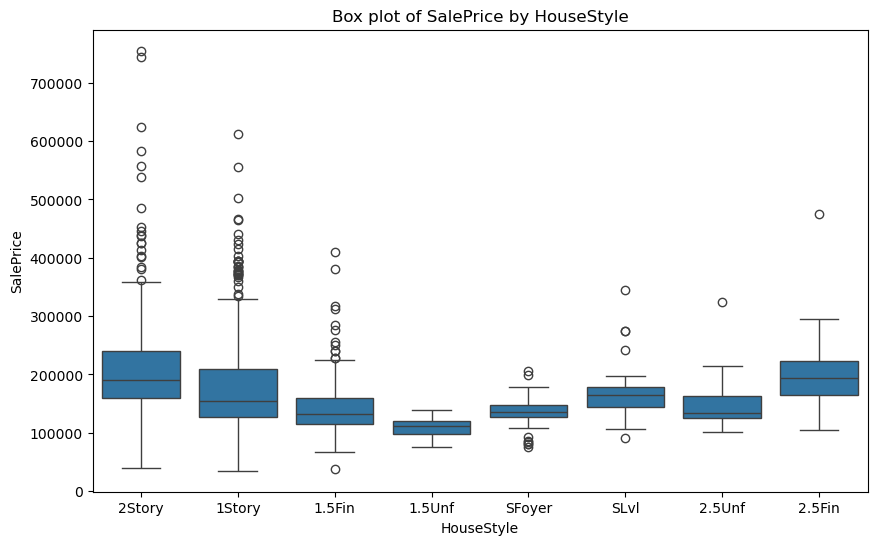

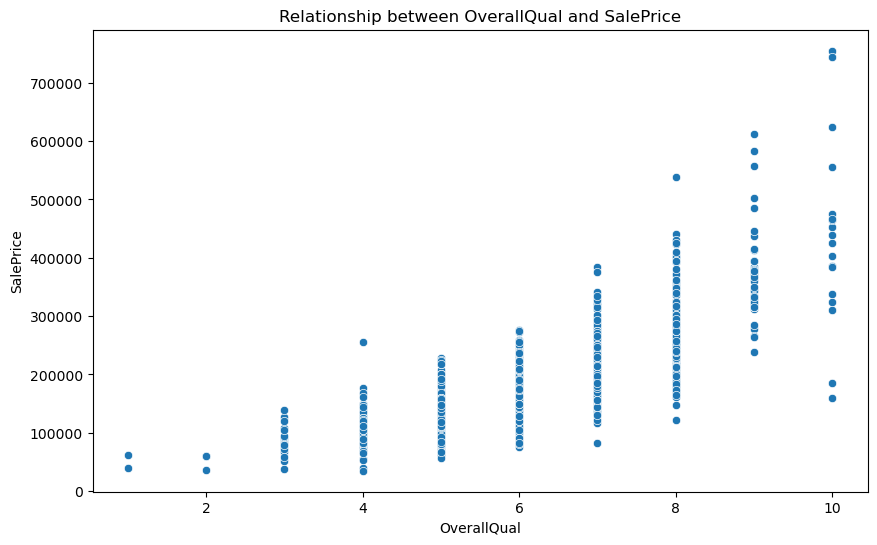

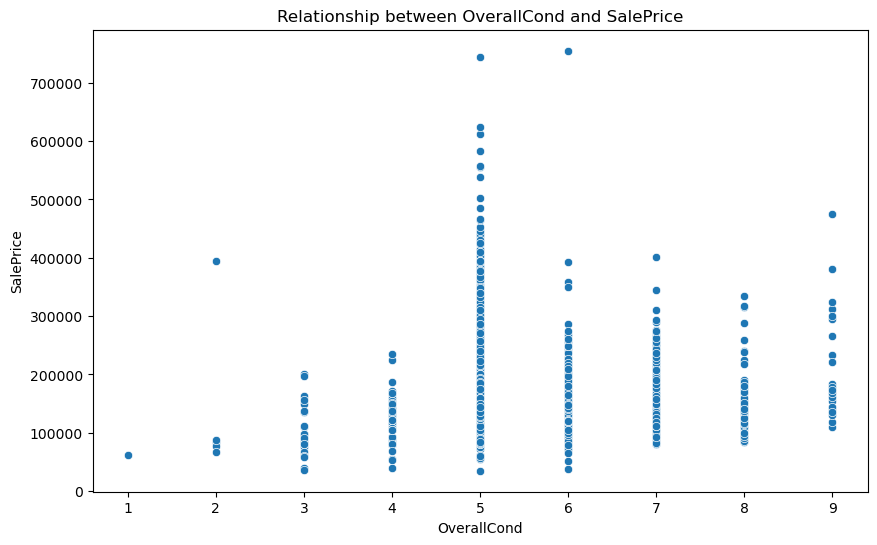

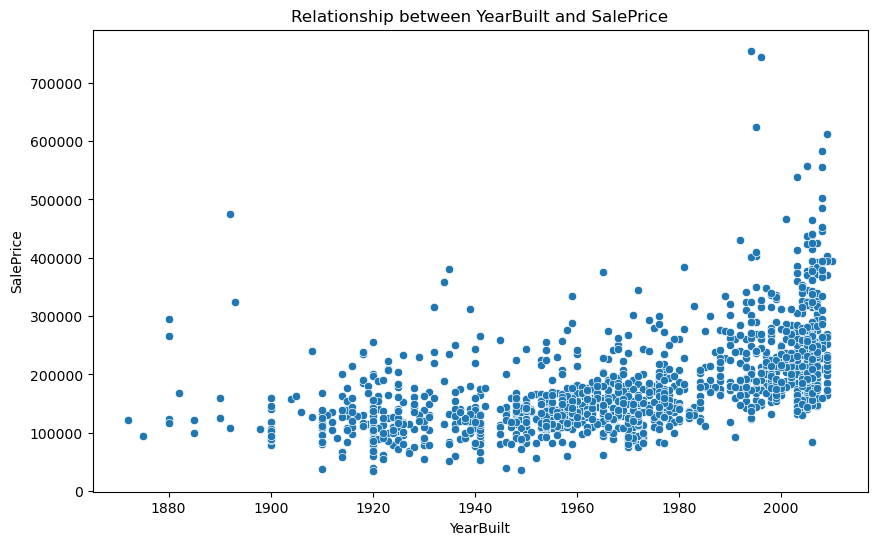

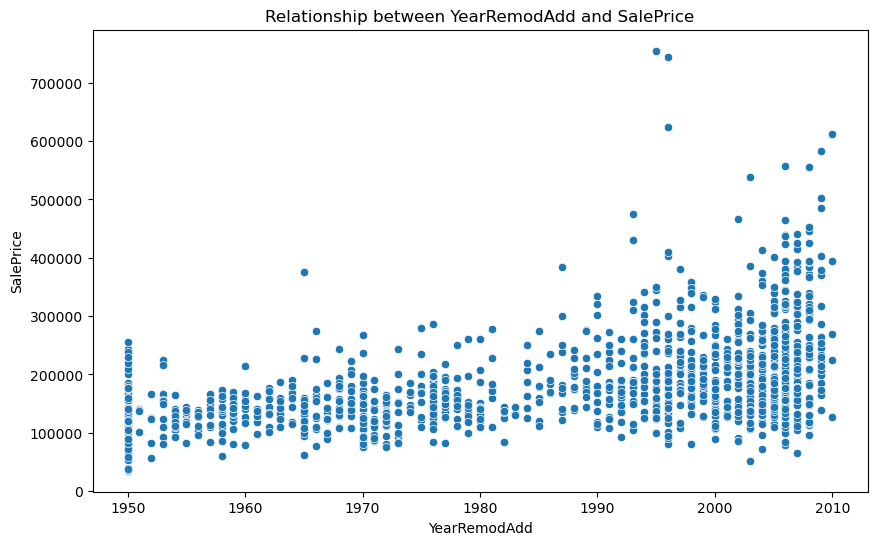

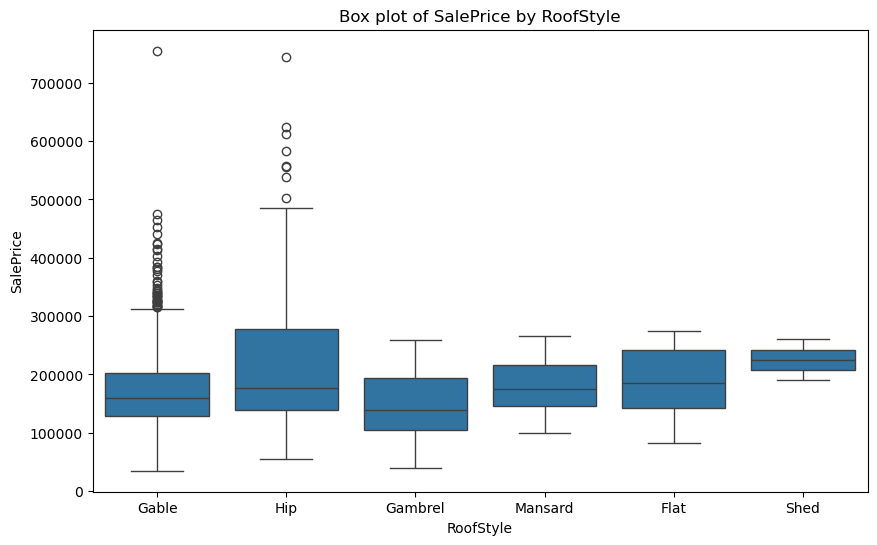

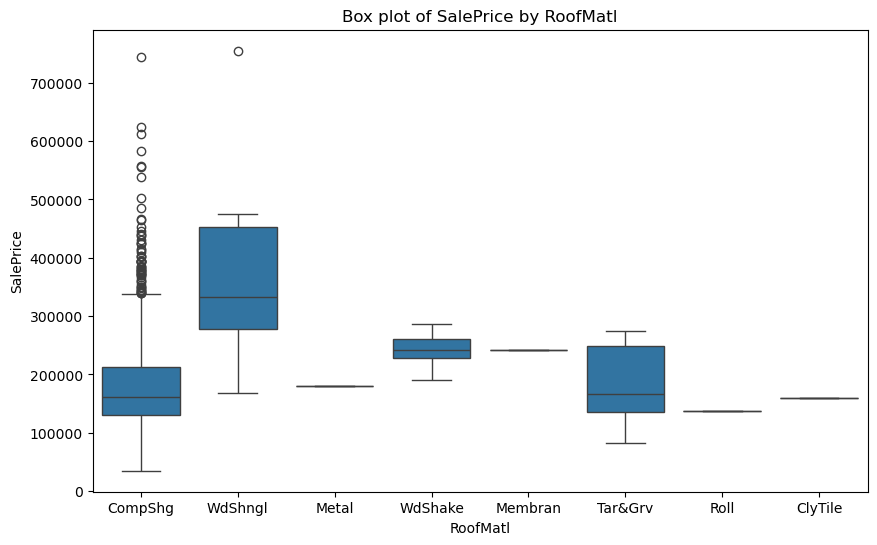

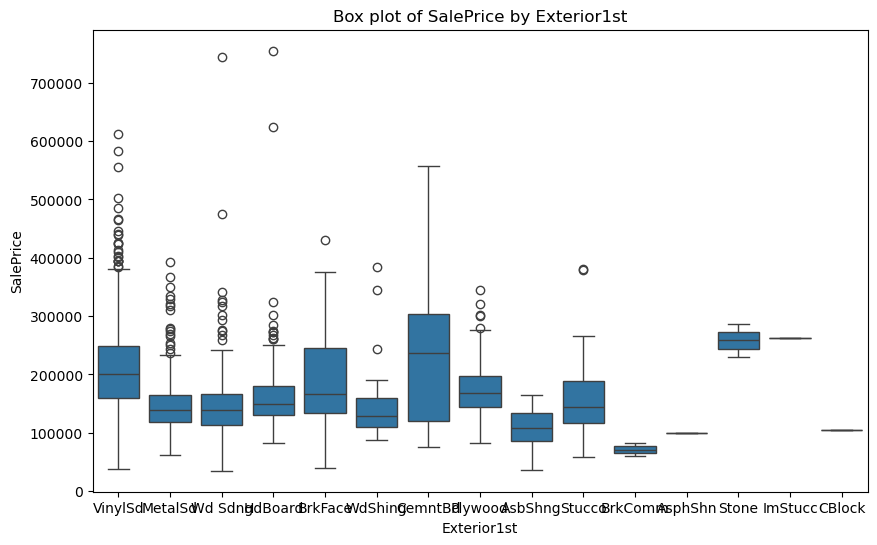

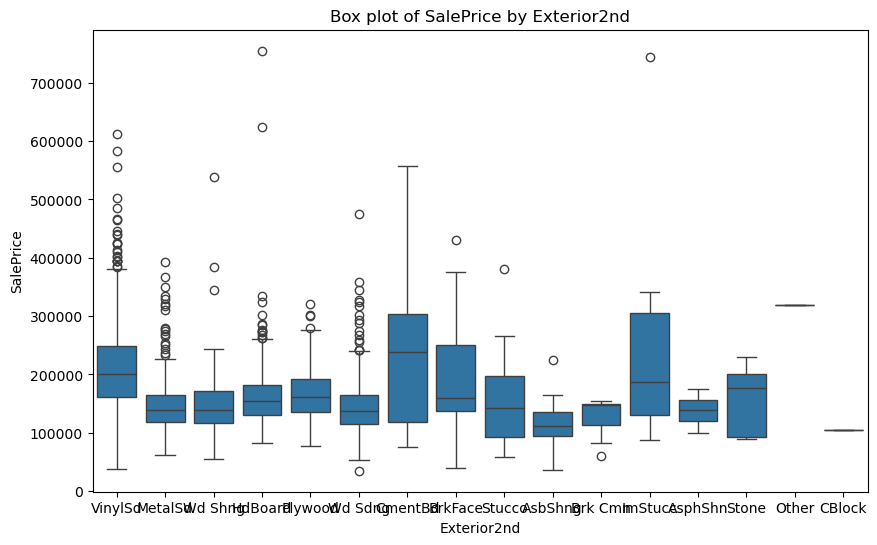

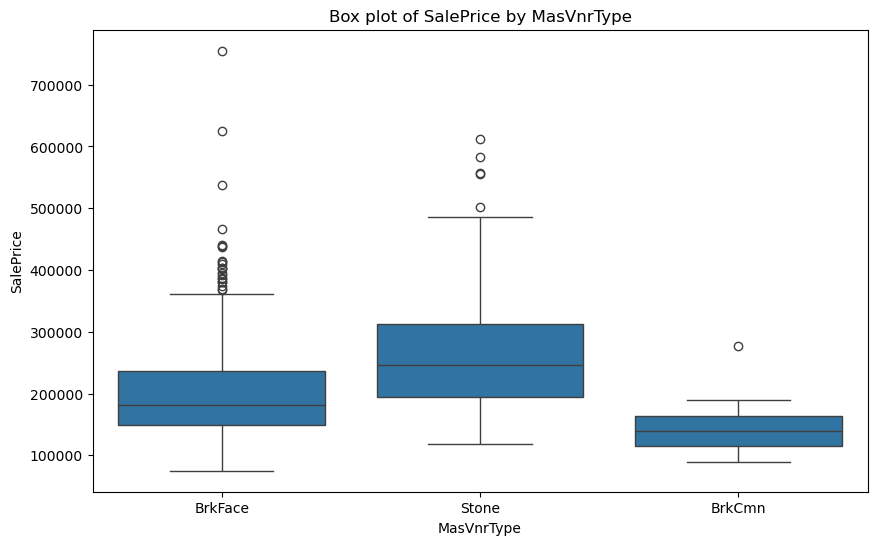

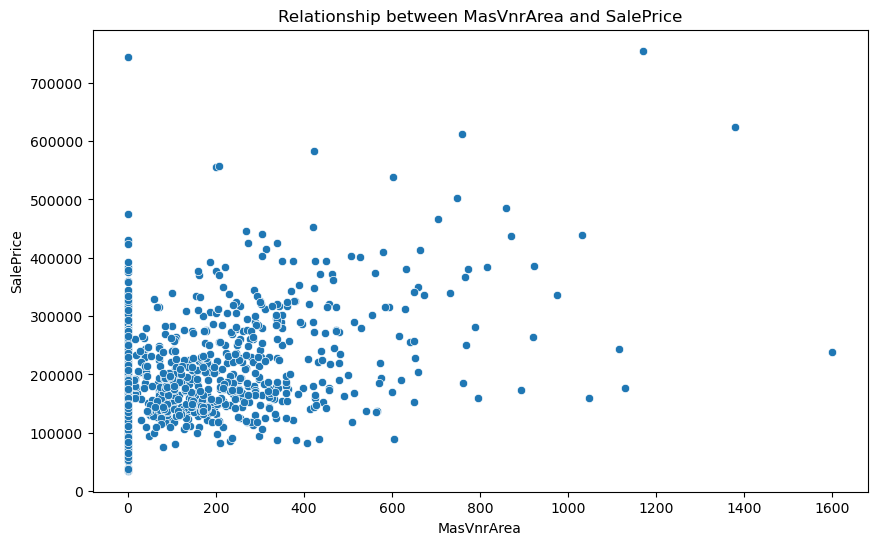

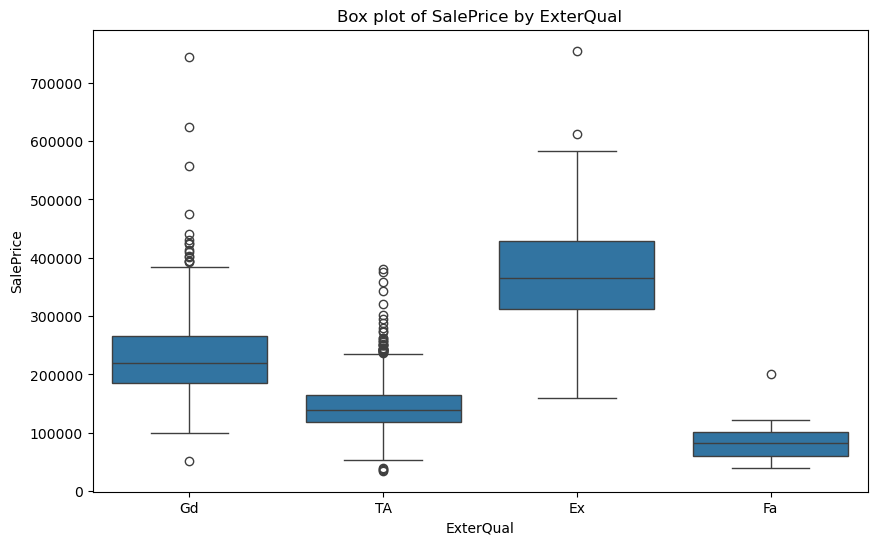

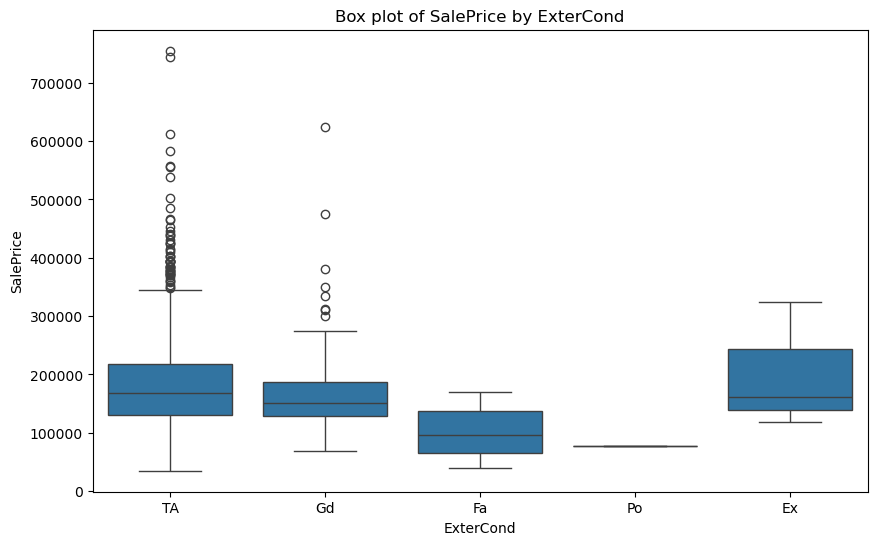

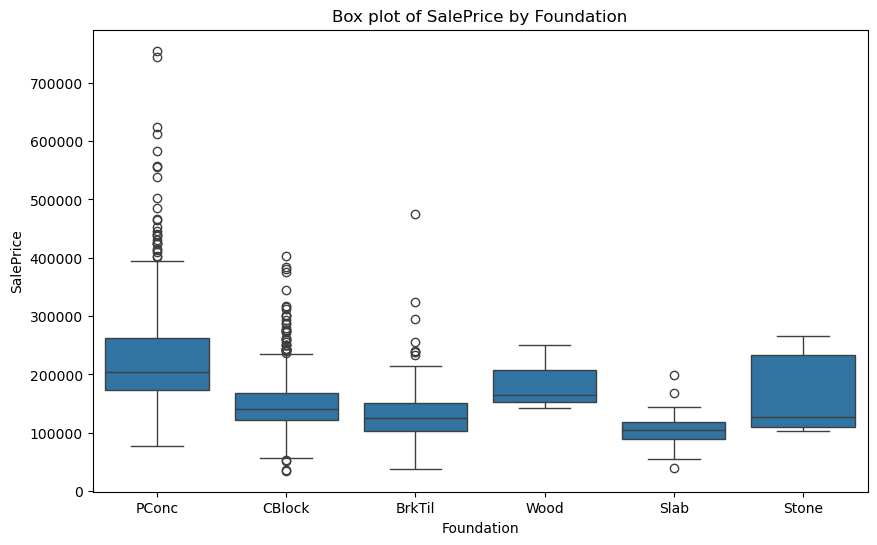

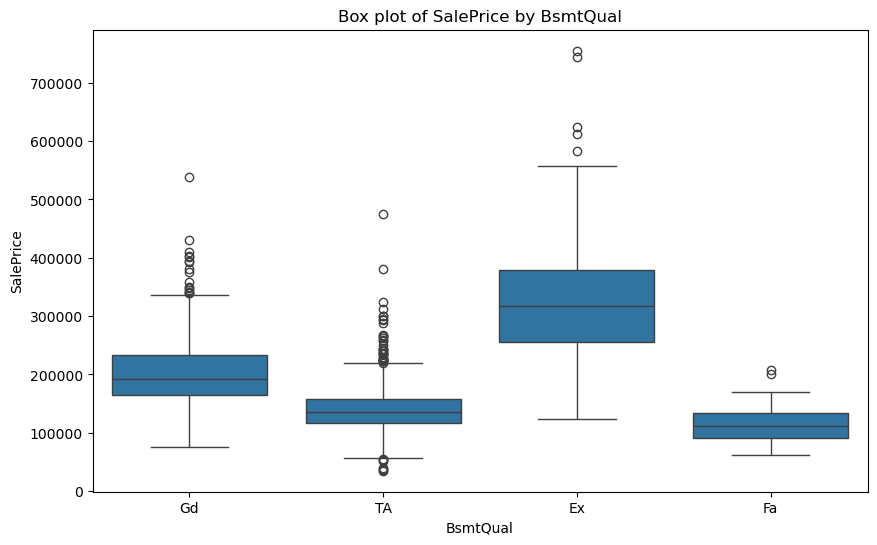

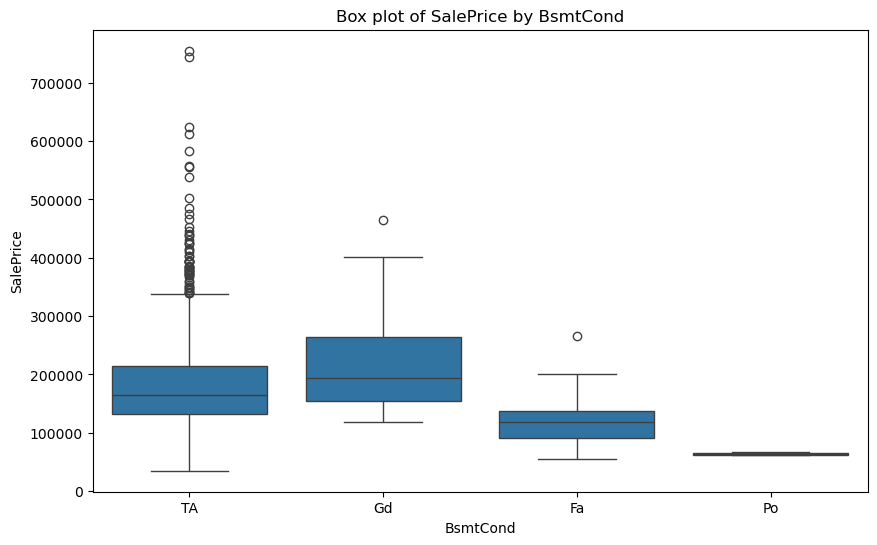

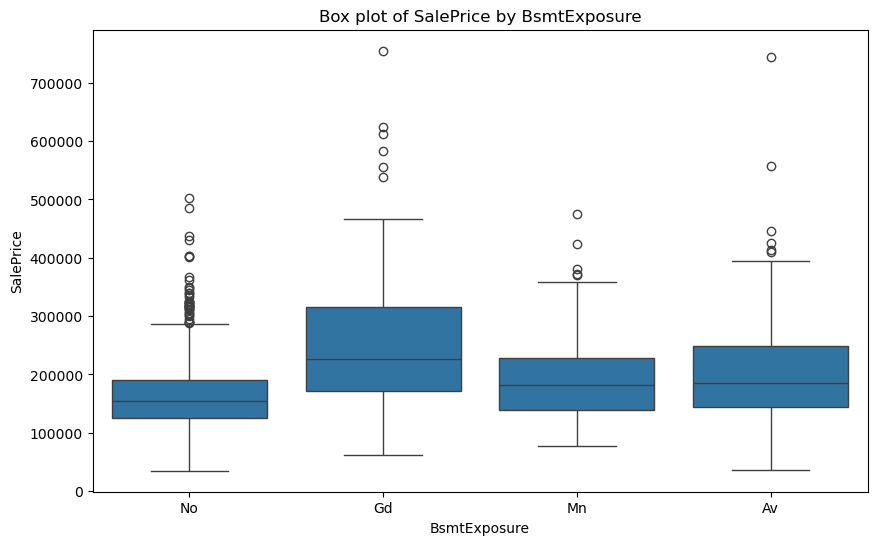

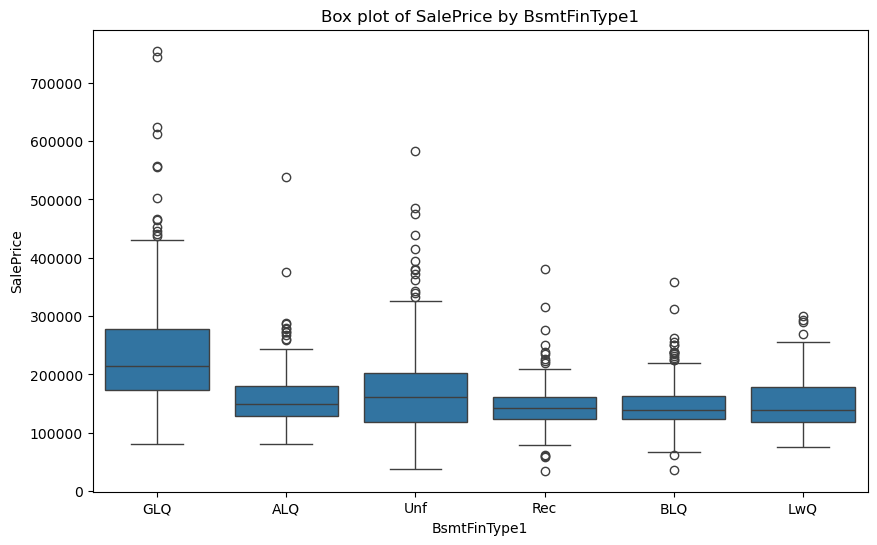

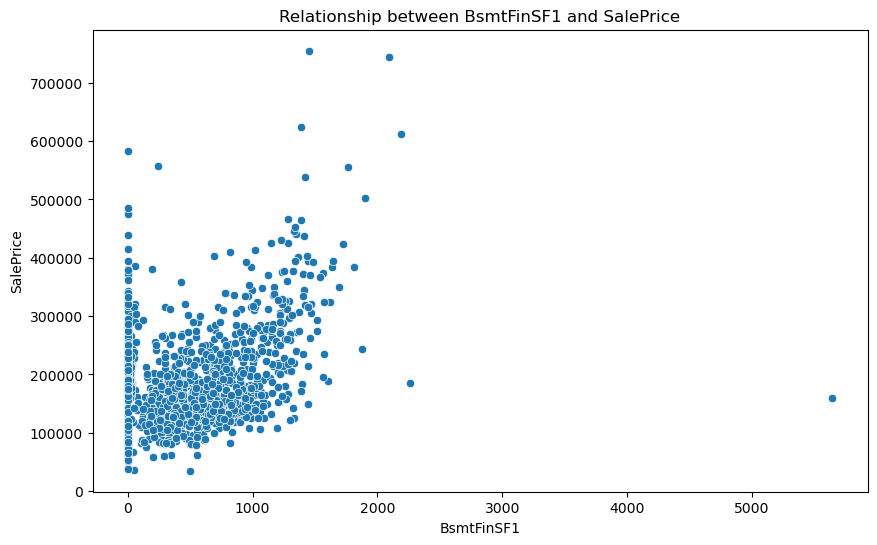

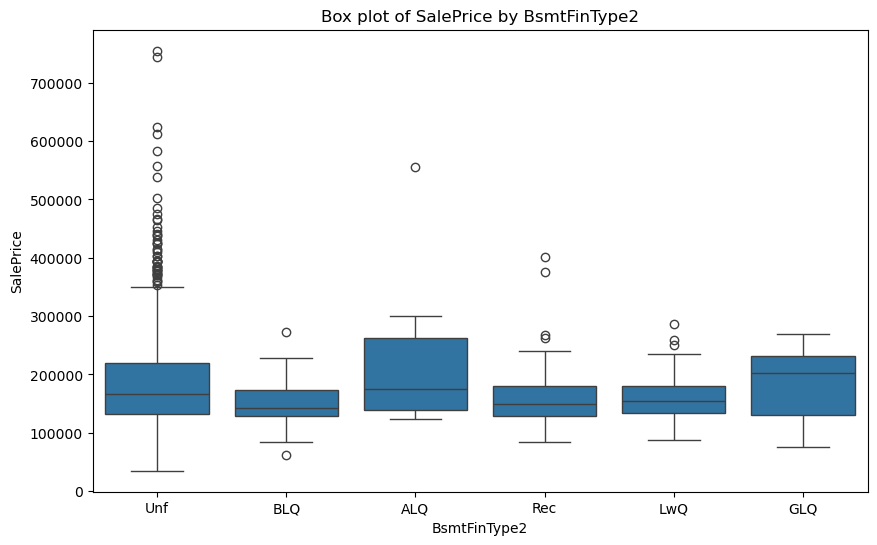

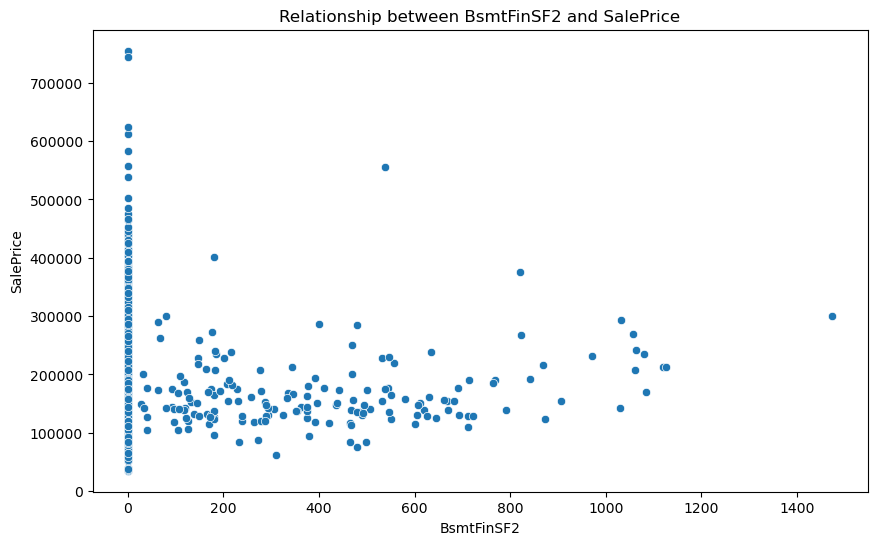

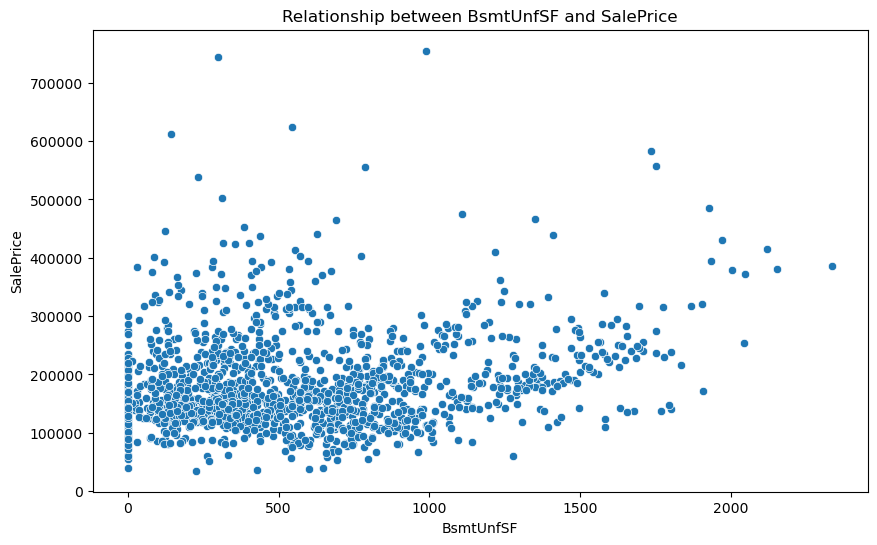

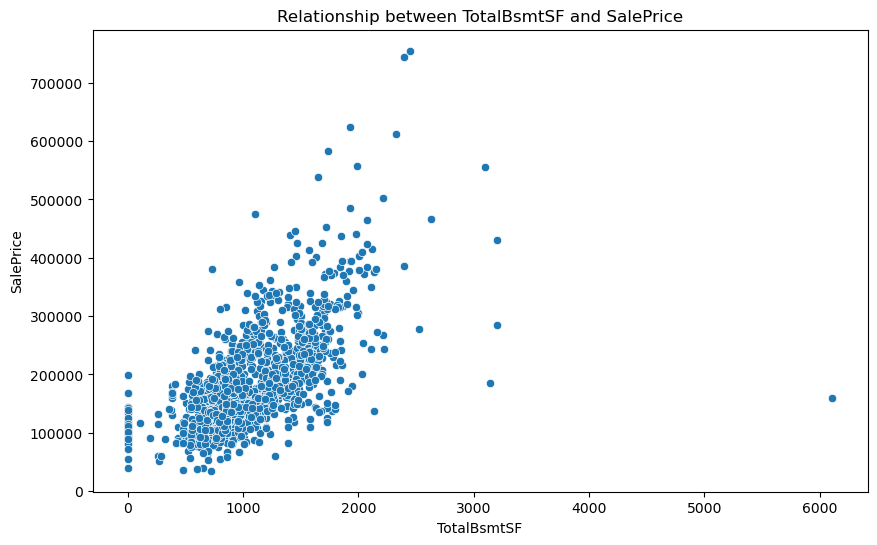

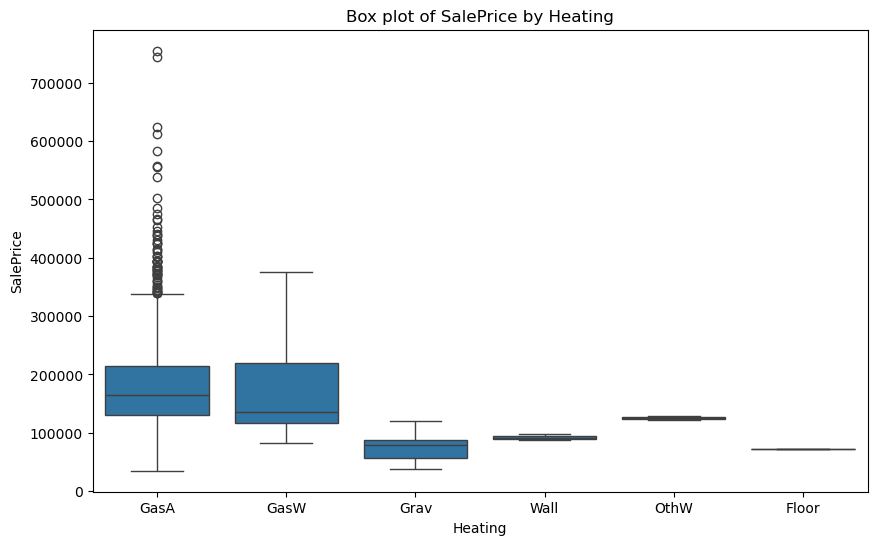

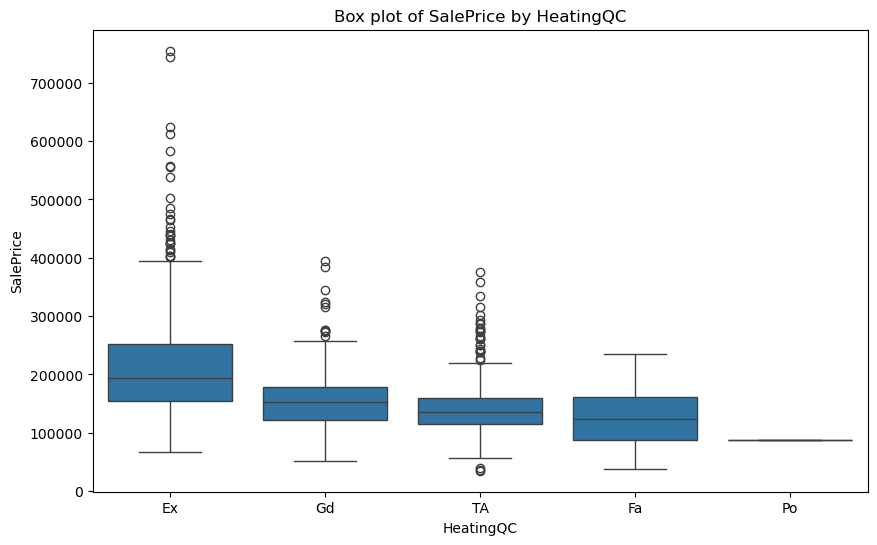

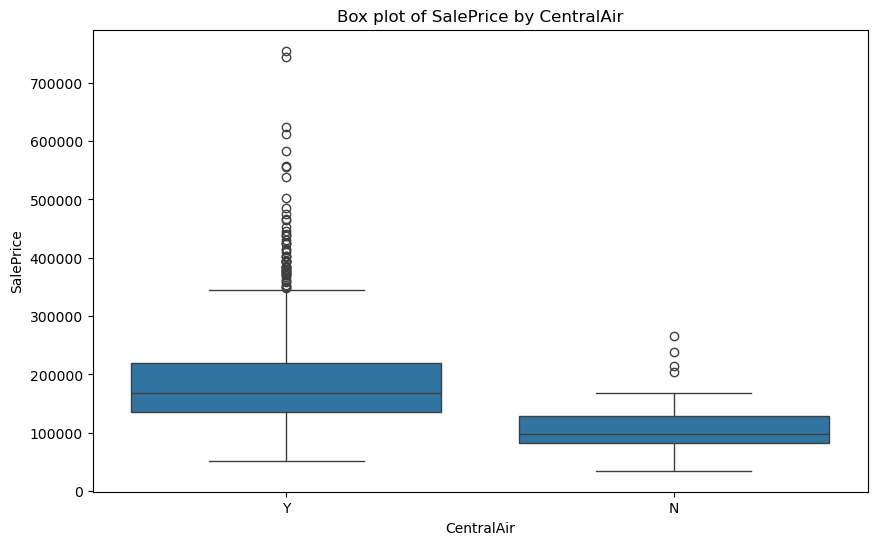

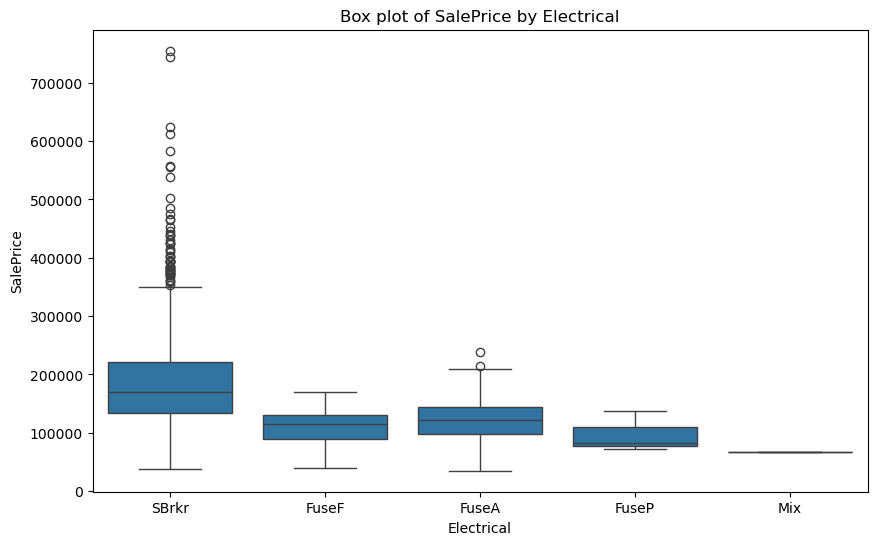

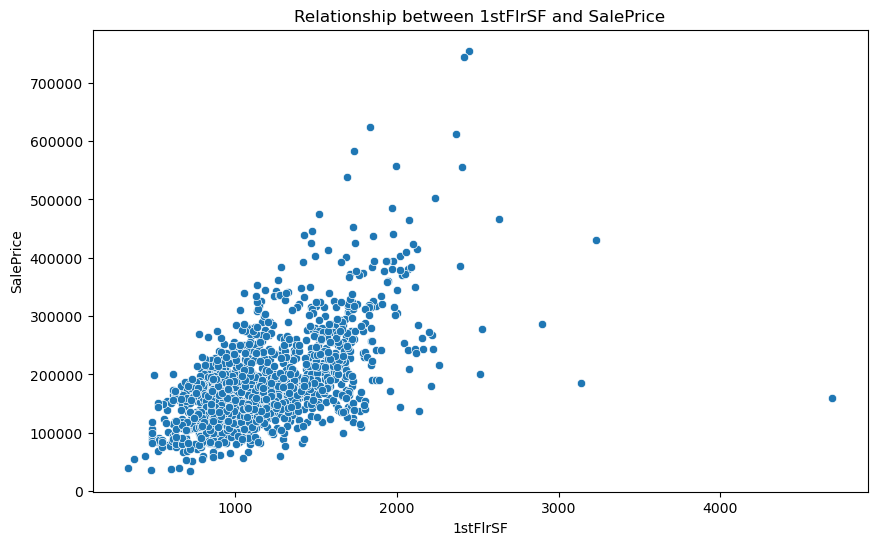

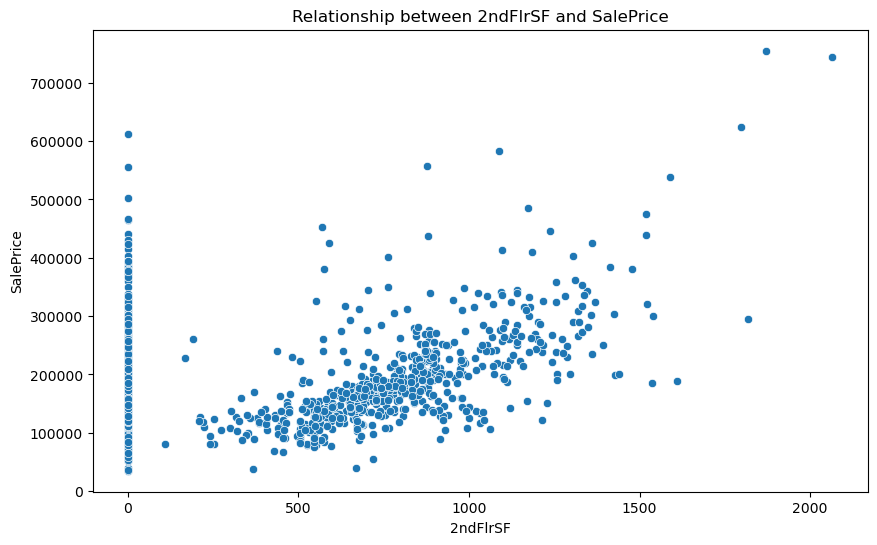

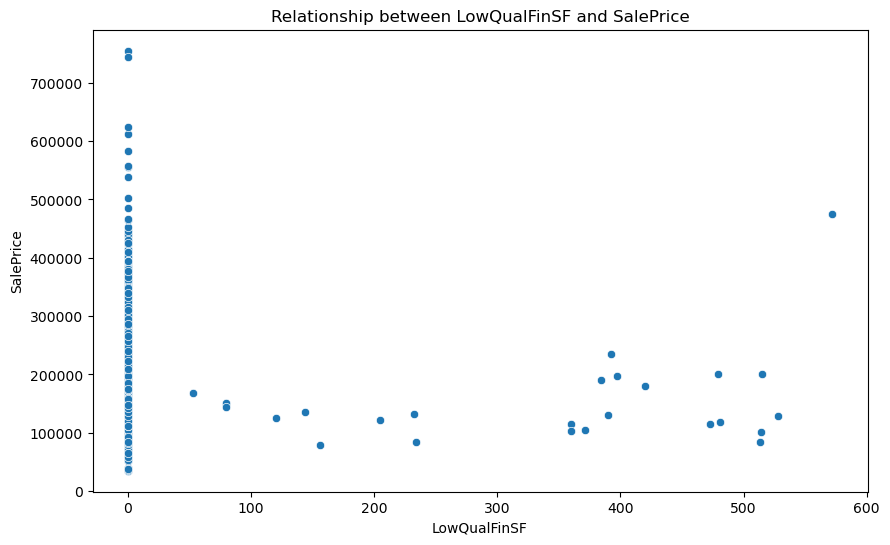

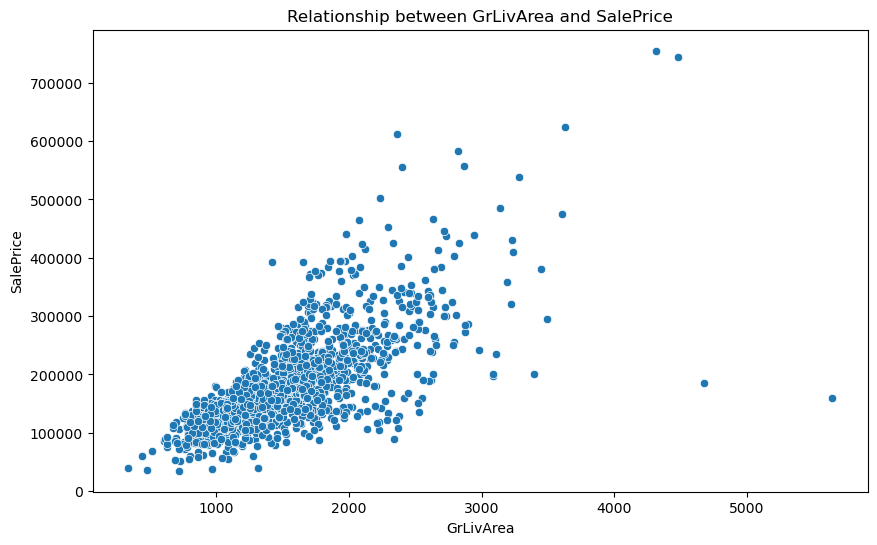

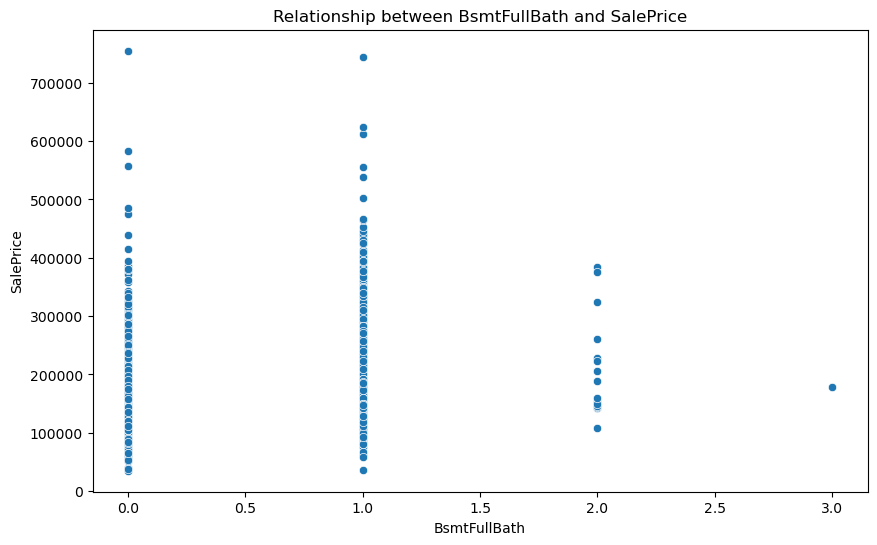

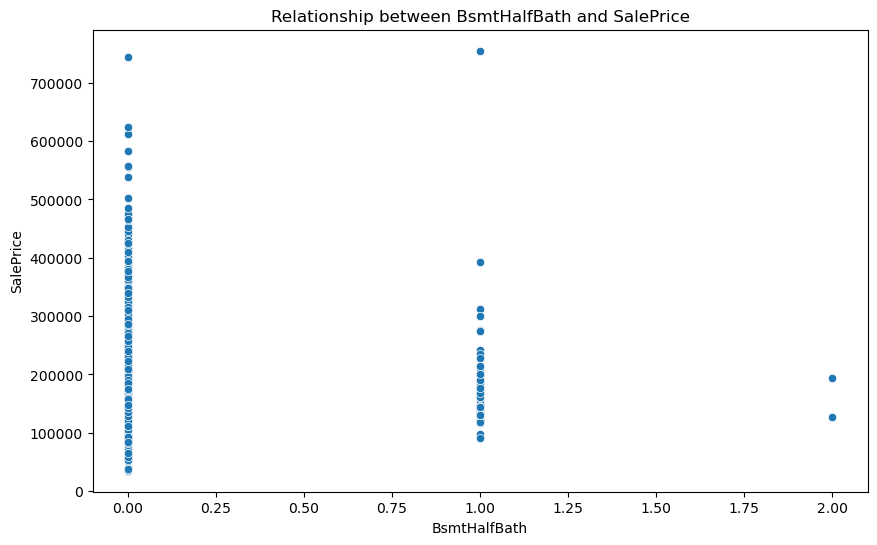

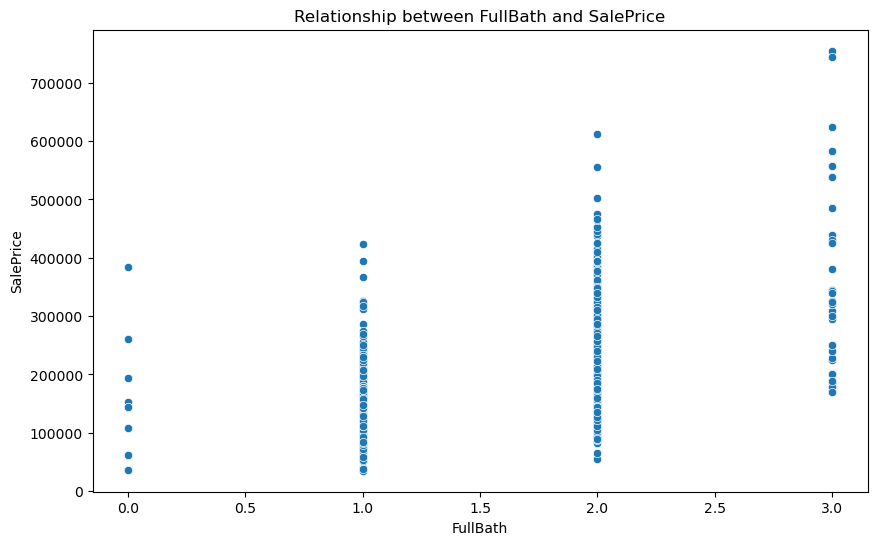

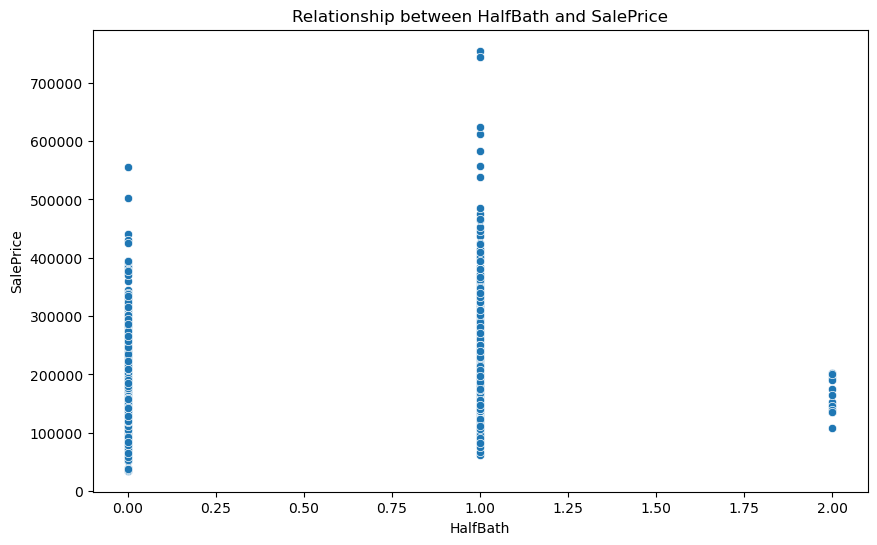

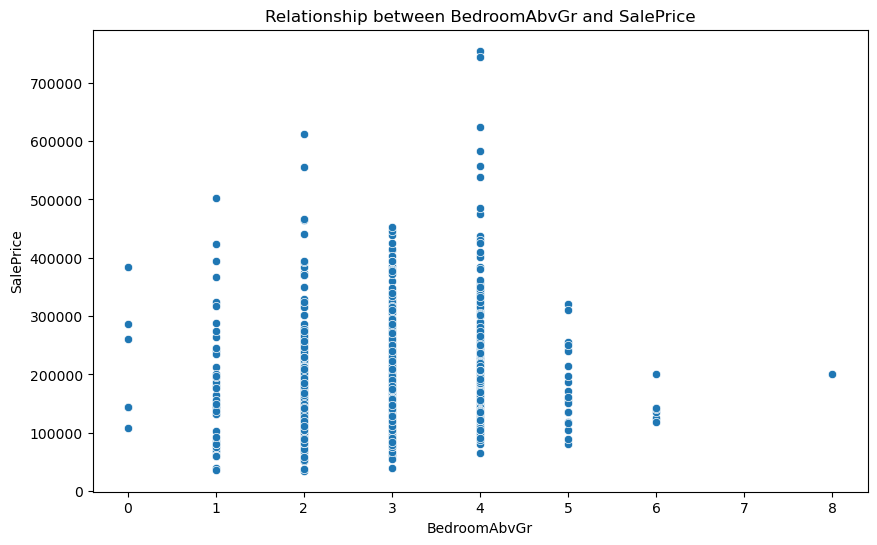

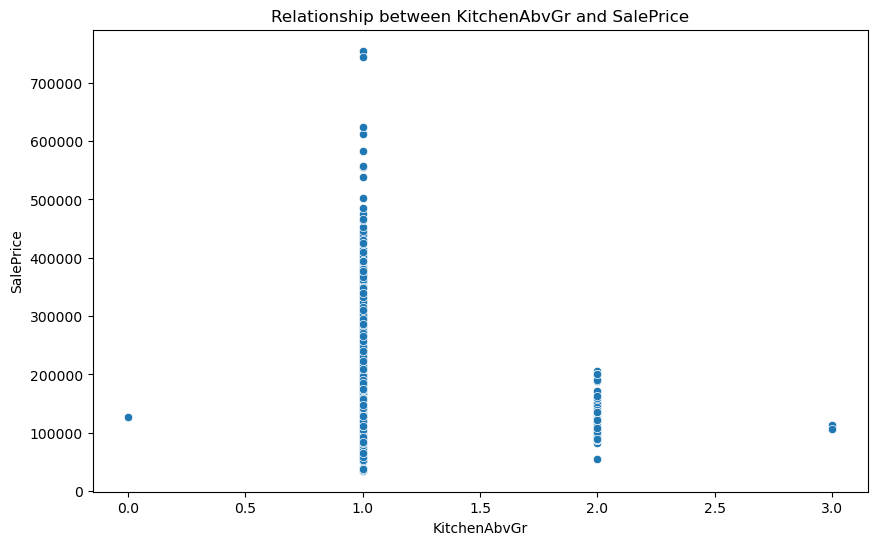

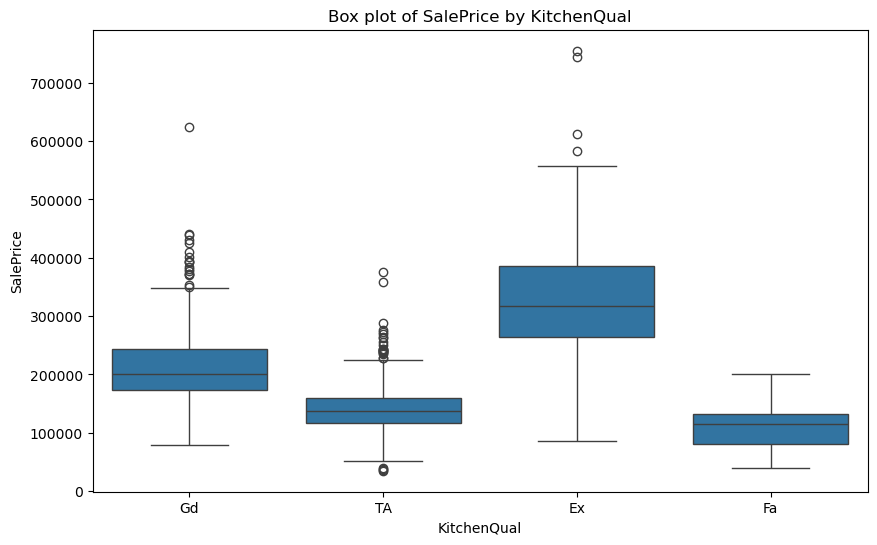

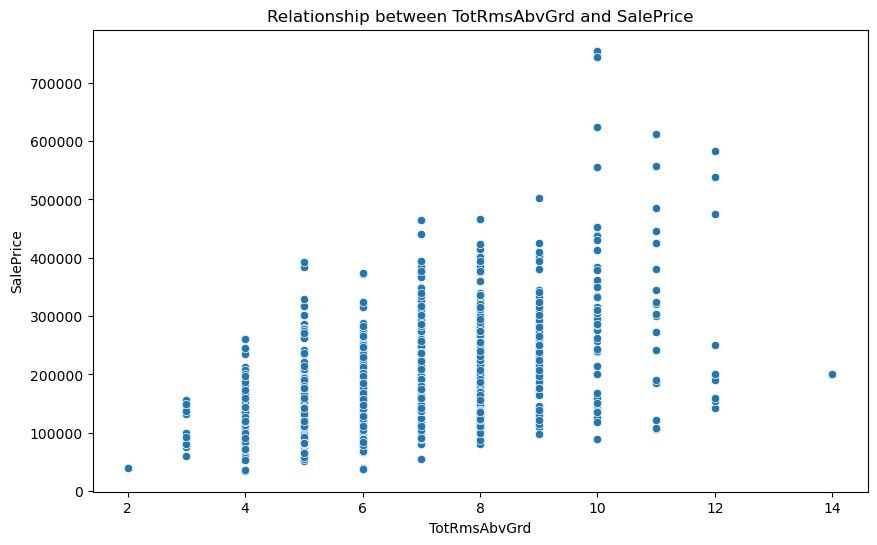

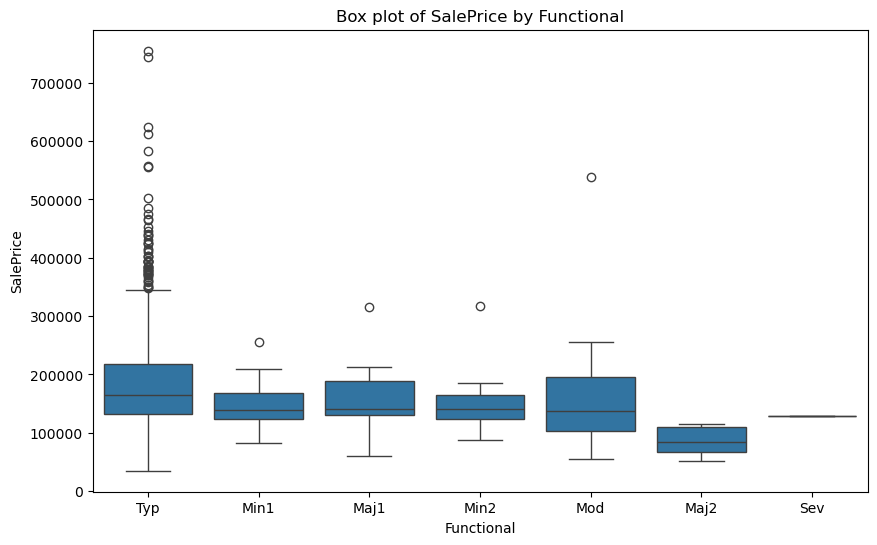

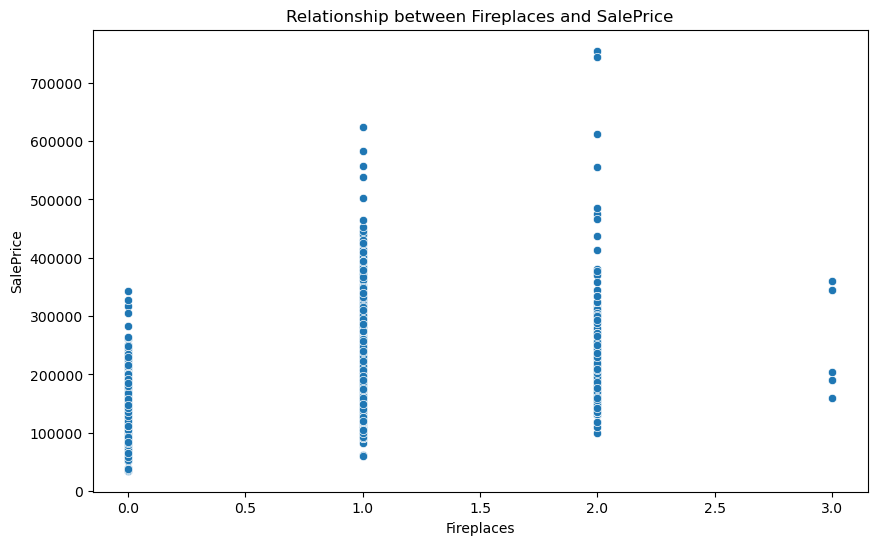

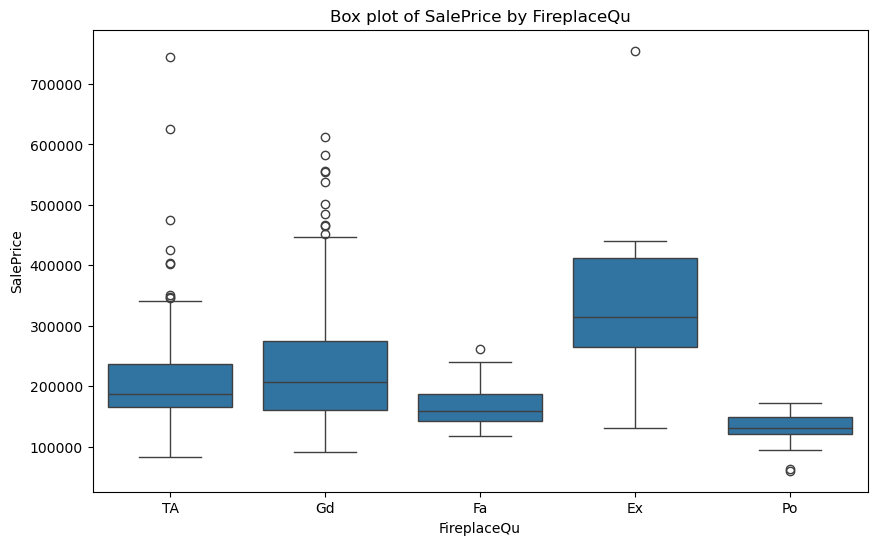

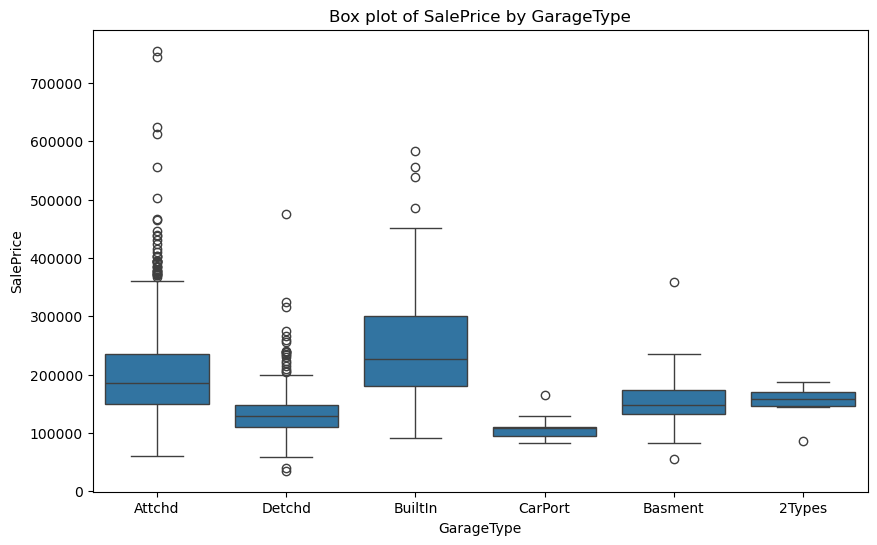

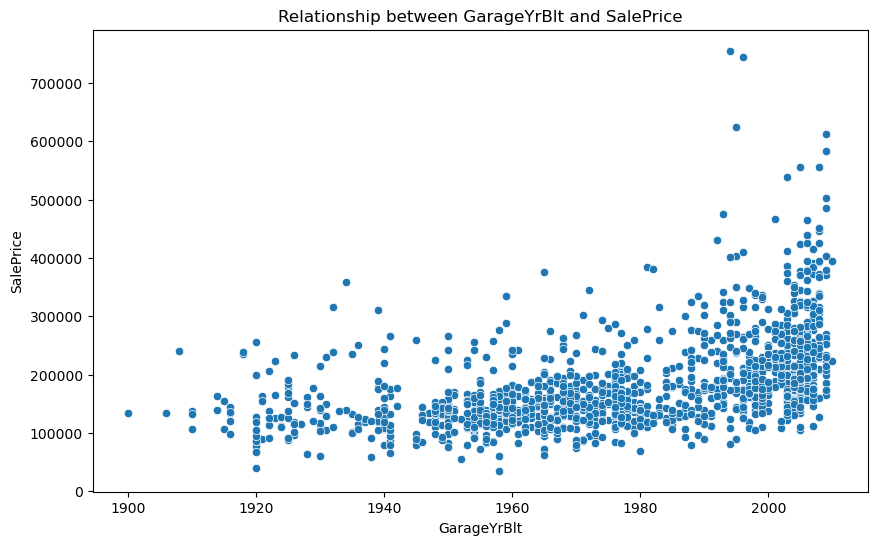

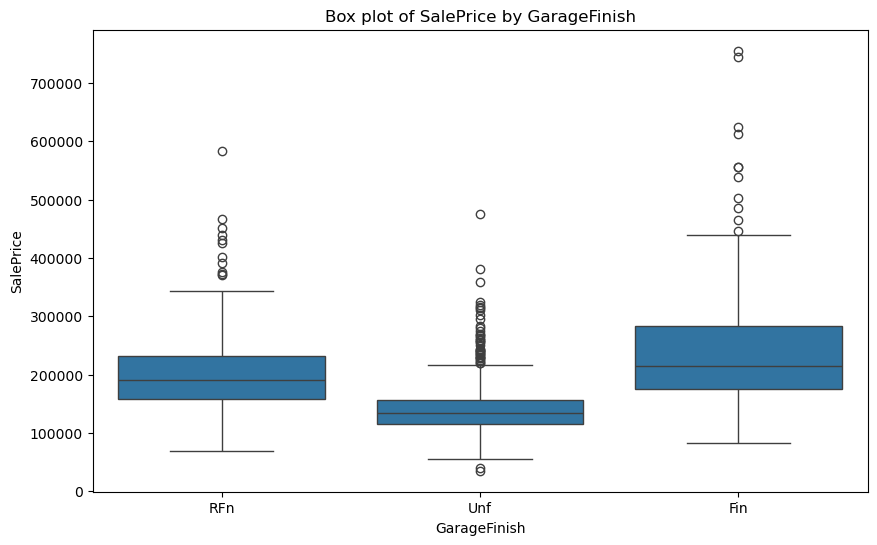

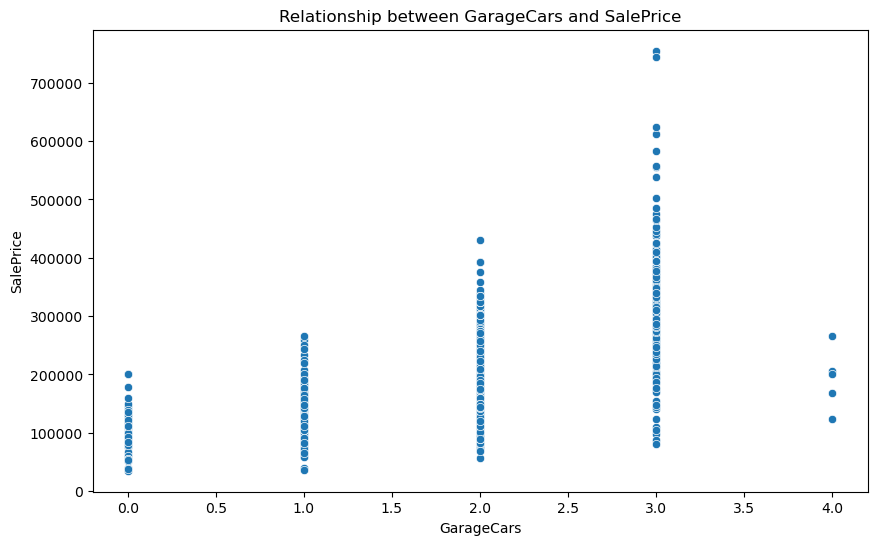

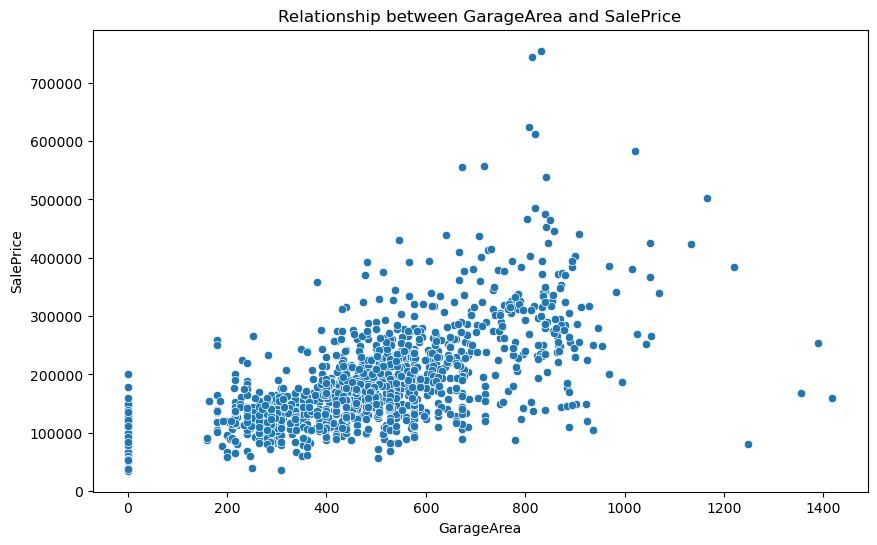

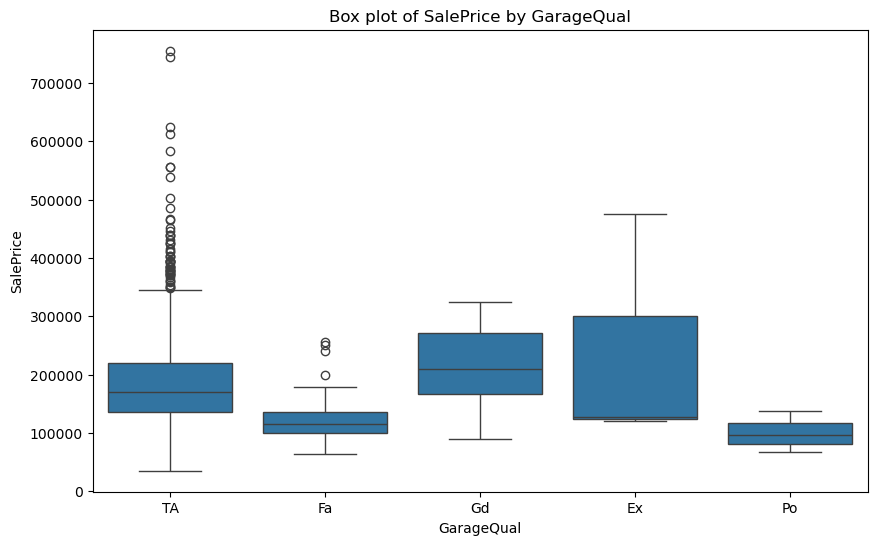

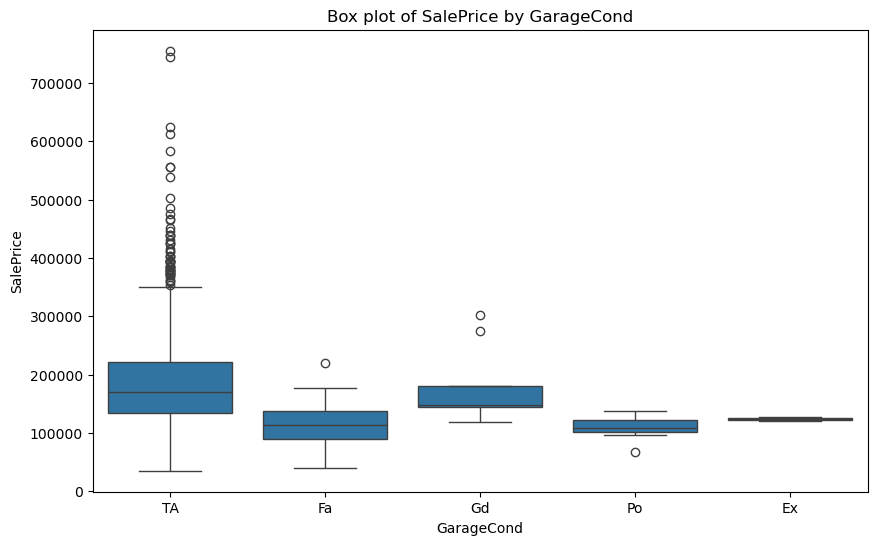

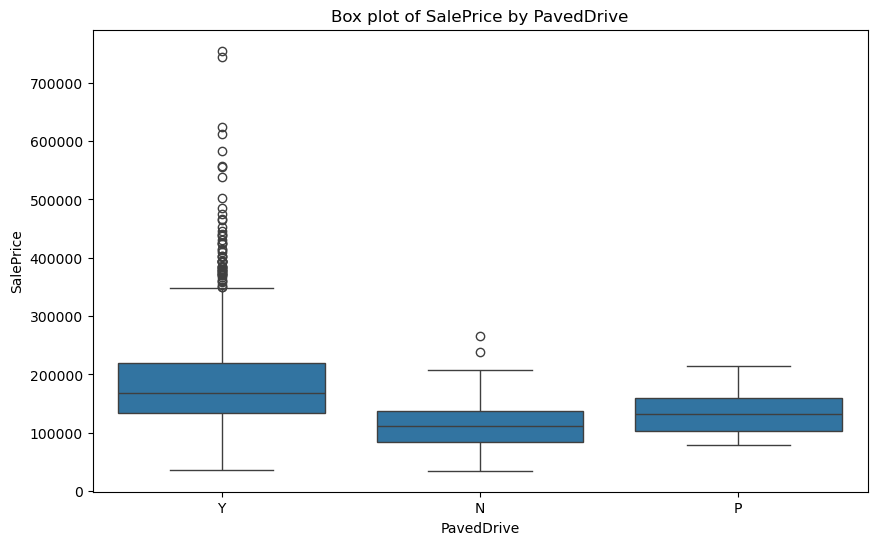

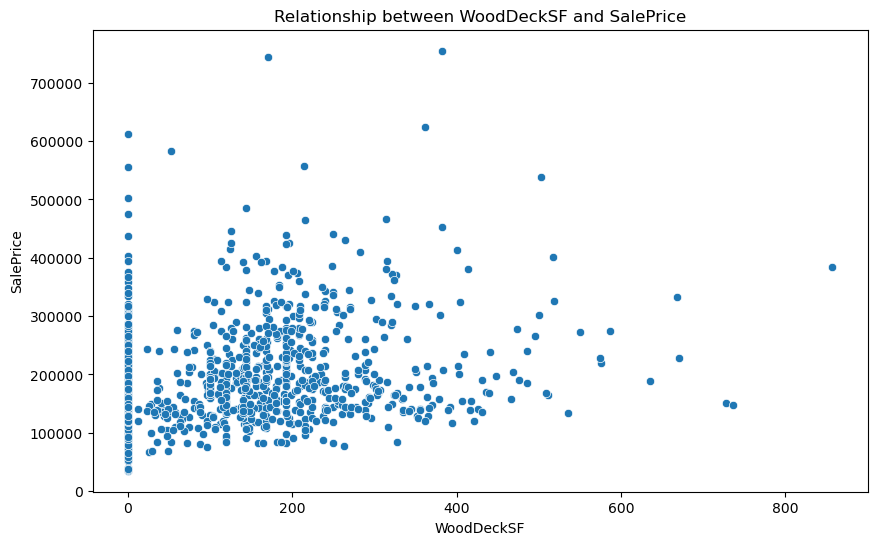

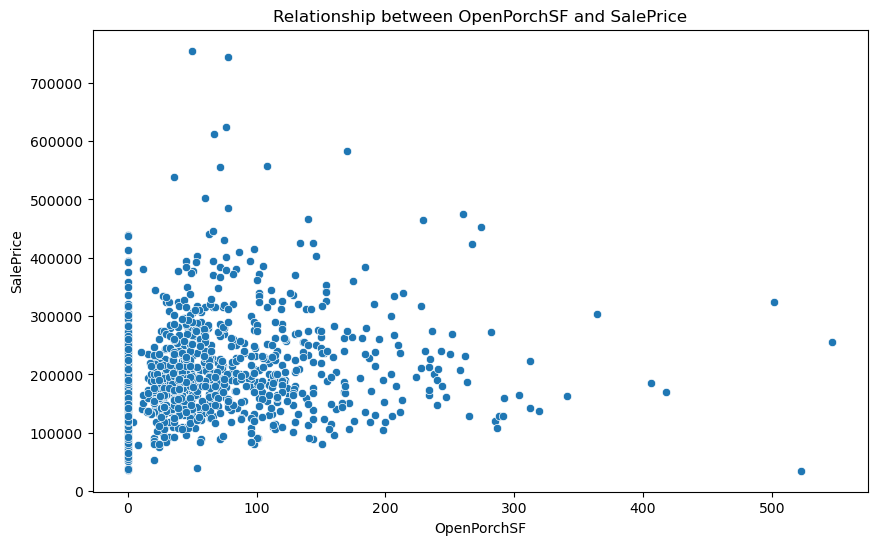

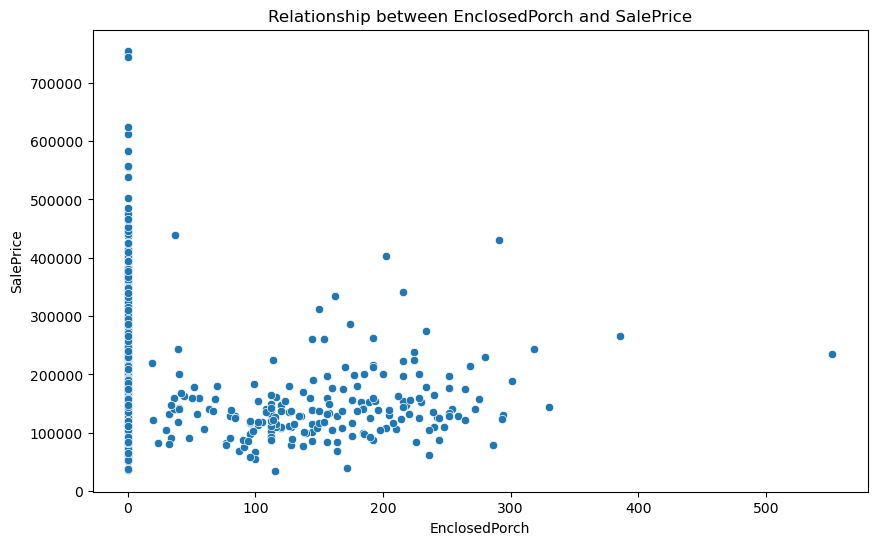

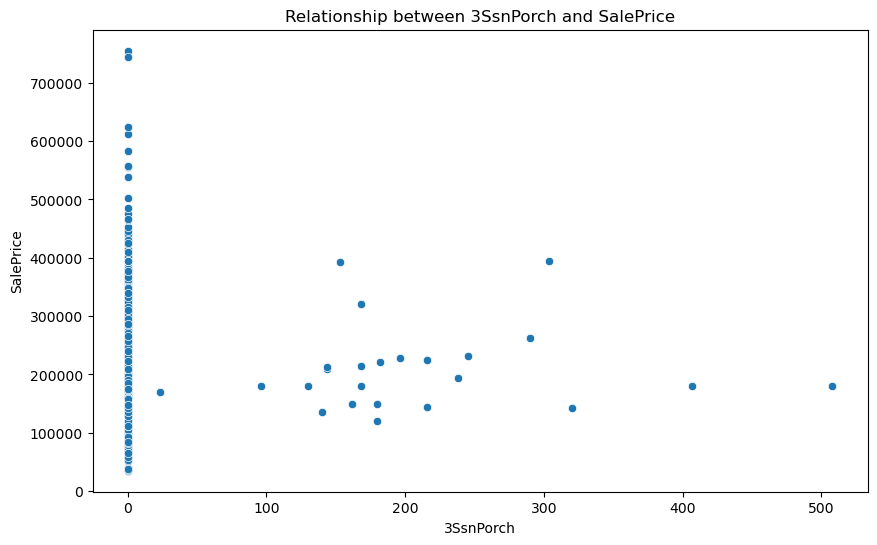

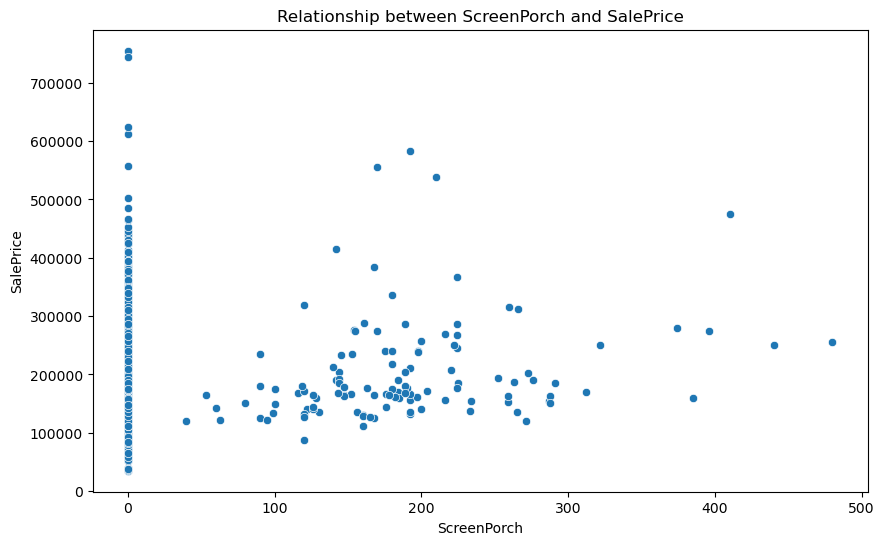

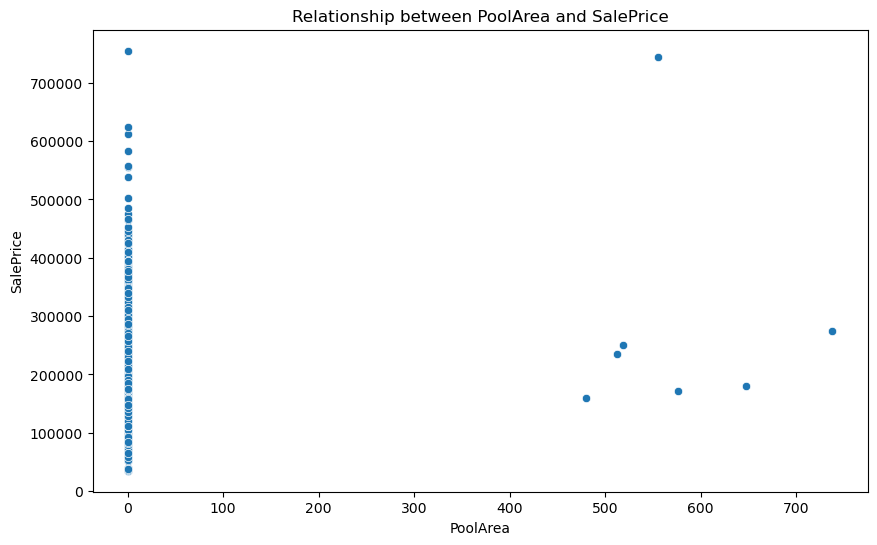

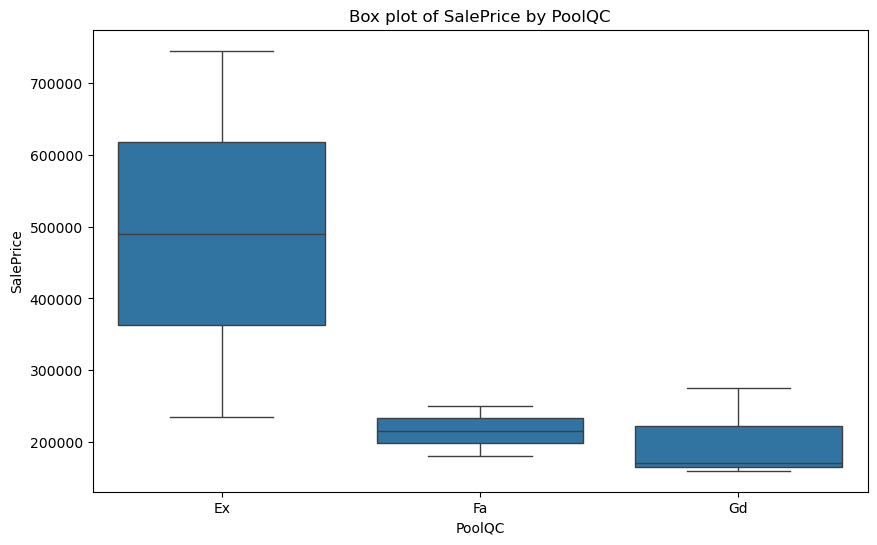

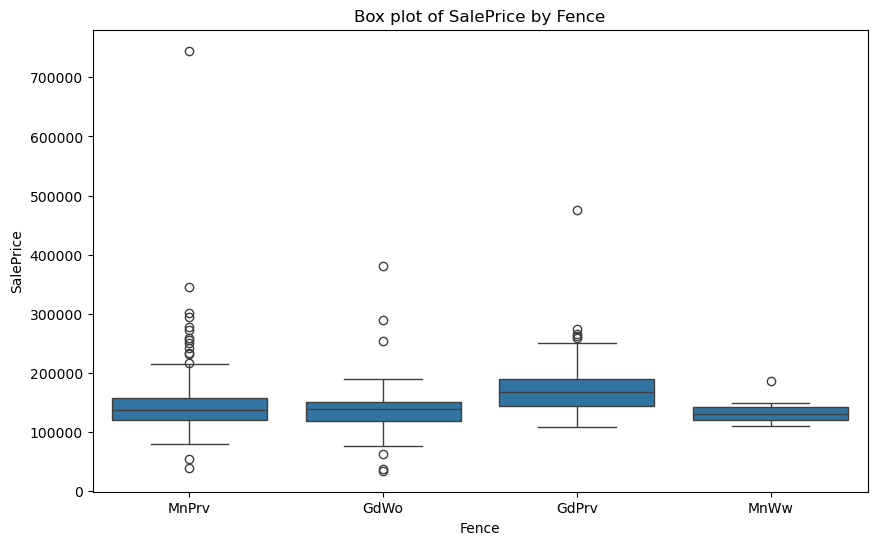

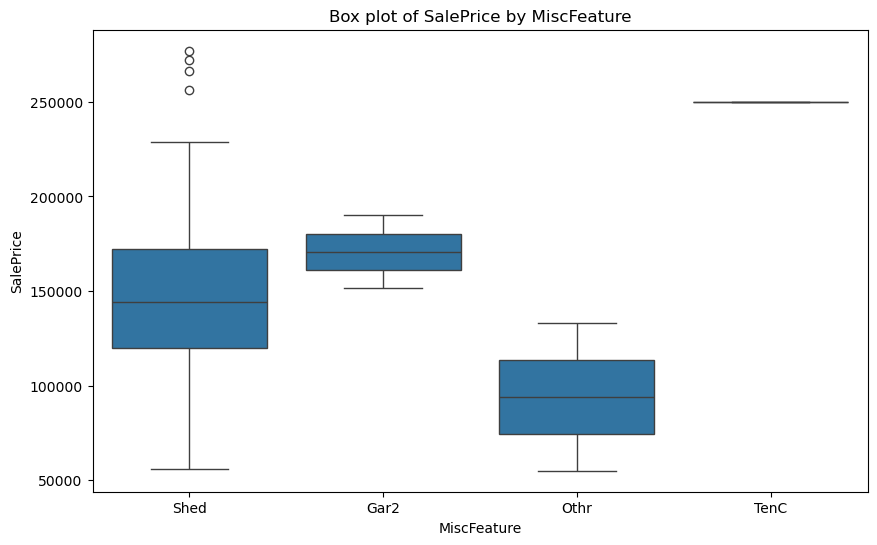

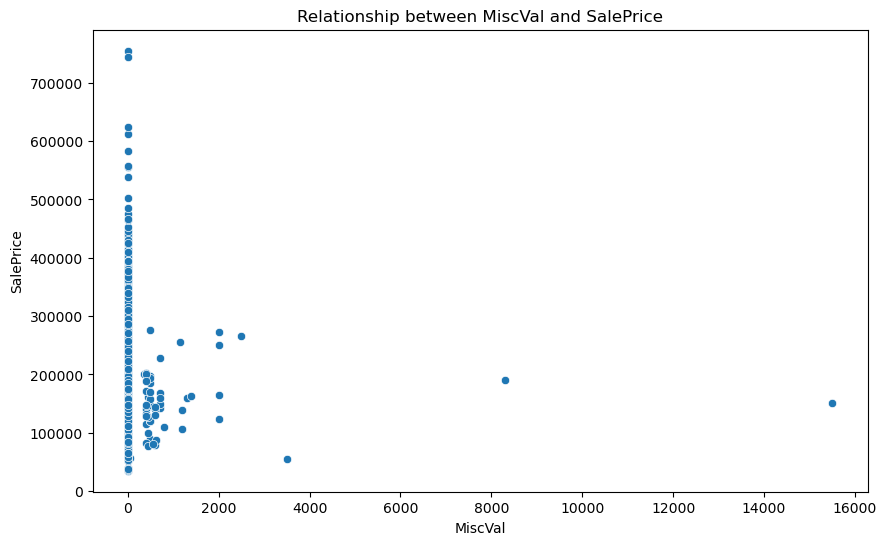

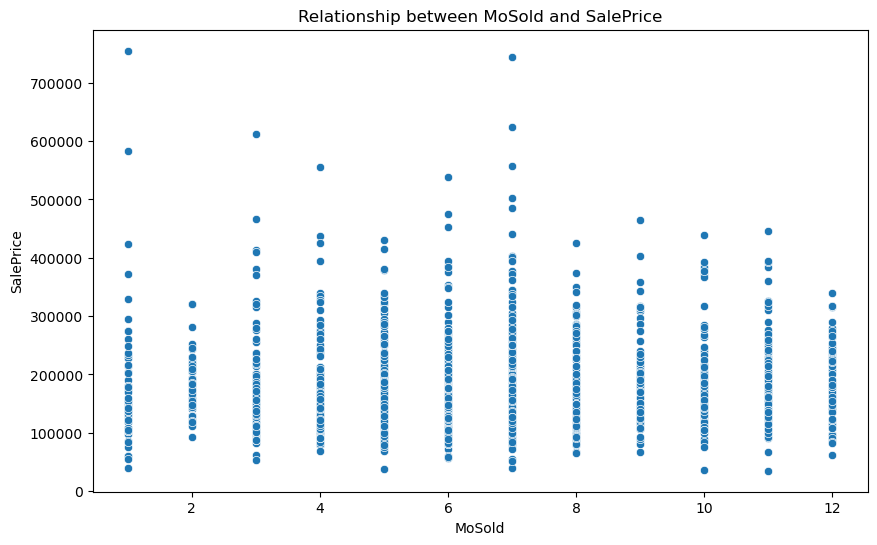

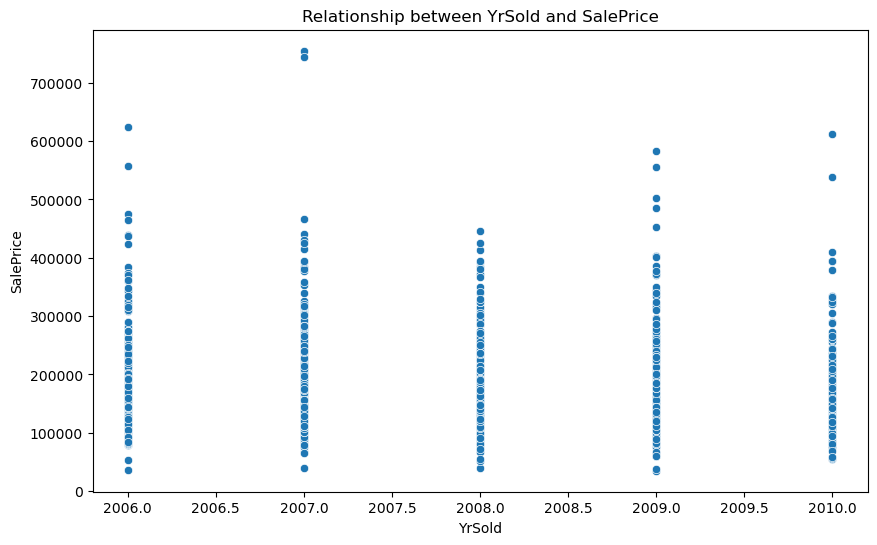

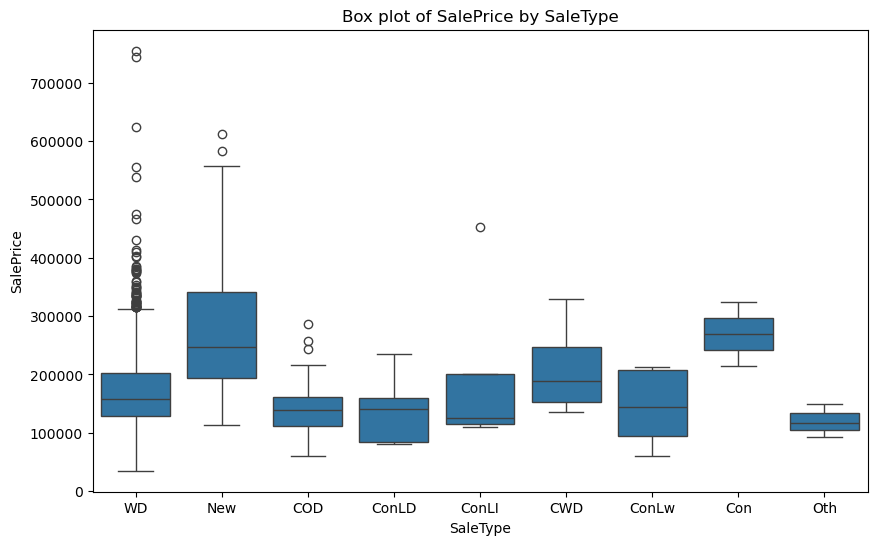

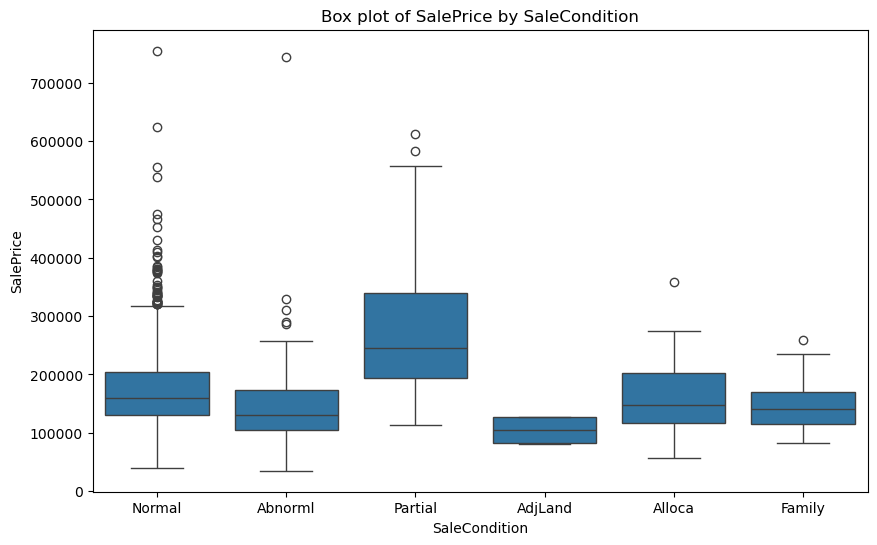

In [13]:
target = 'SalePrice'

for feature in train_df.columns:
    if feature != target:
        plot_bivariate(train_df, feature, target)

# Cleaning

After exploring the dataset, I identified several NaN values that can be filled during preprocessing. Reading the column descriptions provided valuable insights, especially in spotting similar or related features. <br> Additionally, the graphs above helped uncover some outliers, which should be addressed during the data cleaning phase. <br>

Interestingly, when plotting certain features against SalePrice, I noticed that the data points tend to cluster tightly, showing little to no variation. <br> 
This suggests that some features might not contribute much to predicting the target and could potentially be dropped. <br>
A good example of this is the LotArea feature <br>

In [14]:
def drop_features(df, features: list[str]):
    return df.drop(columns=features, axis=1)

def fill_linked_nullable_features(df, features_with_parents, fill_values):
    df = df.copy()

    for parent, features in features_with_parents.items():
        for index, feature in enumerate(features):
            fill_value = fill_values[parent][index]
            mask = (df[parent] == 0) & (df[feature].isna())
            df.loc[mask, feature] = fill_value

            
    return df 

def fill_nullable_features(df, features, fill_values):
    df = df.copy()

    for index, feature in enumerate(features):
        fill_value = fill_values[index]
        mask = (df[feature].isna())
        df.loc[mask, feature] = fill_value

    return df

In [15]:
# Below is a list of features that I believe can be dropped. 
# This decision is based on visual analysis (plots), reading feature descriptions, and observing their lack of impact. 
# I wouldn’t consider this part of formal feature selection — it's more about cleaning the dataset from irrelevant or non-informative columns. 
dropable_features = ['Id', 'LotArea', 'Street', 'Utilities', 'BsmtFinSF2', 'BsmtFinType2', 'BsmtUnfSF', 'PoolQC', 'MoSold']

nullable_features_with_parent = {
    'MiscVal': ['MiscFeature'],
    'GarageArea': ['GarageCond', 'GarageQual', 'GarageFinish', 'GarageYrBlt', 'GarageType'],
    'Fireplaces': ['FireplaceQu'],
    'BsmtFinSF1': ['BsmtFinType1', 'BsmtQual', 'BsmtCond', 'BsmtExposure'],
    'MasVnrArea': ['MasVnrType'],
}

nullable_features_with_parent_fill_values = {
    'MiscVal': ['NA'],
    'GarageArea': ['NA', 'NA', 'NA', 0, 'NA'],
    'Fireplaces': ['NA'],
    'BsmtFinSF1': ['NA', 'NA', 'NA', 'NA'],
    'MasVnrArea': ['NA'],
}

nullable_features = ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'Electrical', 'Fence']
nullable_features_fill_values = [-1, 'Unknown', 'Unknown', -1, 'Unknown', 'Unknown']

train_df = drop_features(train_df, dropable_features)
train_df = fill_linked_nullable_features(train_df, nullable_features_with_parent, nullable_features_with_parent_fill_values)
train_df = fill_nullable_features(train_df, nullable_features, nullable_features_fill_values)

# remove some outliers
train_df = train_df[train_df['LotFrontage'] <= 250]
train_df = train_df[train_df['BsmtFinSF1'] <= 3000]
train_df = train_df[train_df['TotalBsmtSF'] <= 4000]
train_df = train_df[train_df['1stFlrSF'] <= 4000]

train_df = train_df.sort_values(by='GrLivArea', ascending=True)  
train_df = train_df.iloc[:-2]  

train_df.reset_index(drop=True, inplace=True)

# Feature Engineering

In [16]:
def apply_mappings(df, mappings):
    df = df.copy()
    for column, mapping in mappings.items():
        if column in df.columns:
            df[column] = df[column].astype(str).map(mapping)
        else: 
            print(column)
    return df

In [17]:
# Let's start with transforming some categorical features into numerical ones

# got this data from ChatGPT hope it's correct :D 
mappings = {
    "MSSubClass": {
        '20': 1, '30': 2, '40': 3, '45': 4, '50': 5, '60': 6, '70': 7, '75': 8, '80': 9,
        '85': 10, '90': 11, '120': 12, '150': 13, '160': 14, '180': 15, '190': 16
    },
    "Alley": {"Unknown": -1, "NA": 0, "Grvl": 1, "Pave": 2},
    "LotShape": {"IR3": 0, "IR2": 1, "IR1": 2, "Reg": 3},
    "LandContour": {"Low": 0, "HLS": 1, "Bnk": 2, "Lvl": 3},
    "LandSlope": {"Sev": 0, "Mod": 1, "Gtl": 2},
    "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtExposure": {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
    "BsmtFinType1": {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
    "HeatingQC":    { "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5 },
    "KitchenQual":  { "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5  },
    "Functional":   { "Sal": 0, "Sev": 1, "Maj2": 2, "Maj": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7 },
    "FireplaceQu":  { "Na": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5  },
    "GarageFinish": { "Na": 0, "Unf": 1, "RFn": 2, "Fin": 3 },
    "GarageQual":   { "NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5 },
    "GarageCond":   { "NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5 },
}

train_df = apply_mappings(train_df, mappings)

In [18]:
# now let's try to create some new features
train_df["Pool?"] = np.where(train_df["PoolArea"] > 0, 1, 0)
train_df["Fireplace?"] = np.where(train_df["Fireplaces"] > 0, 1, 0)
train_df["Garage?"] = np.where(train_df["GarageType"] != 'NA', 1, 0)
train_df["Remodeled?"] = (train_df["YearBuilt"] != train_df["YearRemodAdd"]).astype(int)
train_df["TotalBath"] = (
    train_df["BsmtFullBath"] + 0.5 * train_df["BsmtHalfBath"] +
    train_df["FullBath"] + 0.5 * train_df["HalfBath"]
)
train_df["RoomDensity"] = train_df["TotRmsAbvGrd"] / (train_df["GrLivArea"] + 1e-6)
train_df["BedroomsPerRoom"] = train_df["BedroomAbvGr"] / (train_df["TotRmsAbvGrd"] + 1e-6)
train_df["TotalLivingSF"] = train_df["GrLivArea"] + train_df["TotalBsmtSF"]
train_df["GarageScore"] = train_df["GarageQual"] + train_df["GarageCond"]
train_df["TotalFinishedSF"] = train_df["1stFlrSF"] + train_df["2ndFlrSF"] + train_df["TotalBsmtSF"]
train_df["Porch?"] = (
    (train_df["OpenPorchSF"] > 0) |
    (train_df["EnclosedPorch"] > 0) |
    (train_df["3SsnPorch"] > 0) |
    (train_df["ScreenPorch"] > 0)
).astype(int)
train_df['HouseStyle'] = train_df['HouseStyle'].map({
    '1.5Unf': 'Unfinished',
    '2.5Unf': 'Unfinished',
    '1Story': 'Finished',
    '1.5Fin': 'Finished',
    '2Story': 'Finished',
    '2.5Fin': 'Finished'
}).fillna('Split')

dropable_features_2 = ["PoolArea", "YearBuilt", "YearRemodAdd"]
train_df = drop_features(train_df, dropable_features_2)

# Feature Selection 

In [19]:
price_corr_matrix = train_df.corr(numeric_only=True)

# Get correlation of all numerical features with SalePrice, sorted
saleprice_corr = price_corr_matrix['SalePrice'].sort_values(ascending=False)

print(saleprice_corr)

SalePrice          1.000000
TotalFinishedSF    0.829018
TotalLivingSF      0.825116
OverallQual        0.797967
GrLivArea          0.727486
ExterQual          0.694587
KitchenQual        0.663847
TotalBsmtSF        0.650027
GarageCars         0.644828
TotalBath          0.634321
GarageArea         0.633036
1stFlrSF           0.628608
BsmtQual           0.588997
FullBath           0.560315
TotRmsAbvGrd       0.537187
GarageFinish       0.516633
MasVnrArea         0.489613
Fireplace?         0.475918
Fireplaces         0.468056
HeatingQC          0.431043
BsmtFinSF1         0.399784
BsmtExposure       0.376324
WoodDeckSF         0.328060
OpenPorchSF        0.324965
FireplaceQu        0.309436
2ndFlrSF           0.308855
BsmtFinType1       0.304727
Porch?             0.299926
HalfBath           0.284219
GarageQual         0.277387
GarageScore        0.274791
GarageCond         0.266530
GarageYrBlt        0.264642
Garage?            0.239815
BsmtFullBath       0.226631
BsmtCond           0

In [20]:
selected_num_features = train_df[[
    "TotalFinishedSF", "TotalLivingSF", "OverallQual", "GrLivArea", "ExterQual",
    "KitchenQual", "TotalBsmtSF", "GarageCars", "TotalBath", "GarageArea", 
    "1stFlrSF", "BsmtQual", "FullBath", "TotRmsAbvGrd", "Fireplace?", 
    "HeatingQC", "BsmtFinSF1", "BsmtExposure", "Porch?", "OpenPorchSF", 
    "WoodDeckSF", "RoomDensity", "LotShape", "BedroomsPerRoom", "SalePrice"
]]

selected_categorical_features = train_df[[
    'Neighborhood', 'HouseStyle', 'MasVnrType', 
    'Foundation', 'SaleCondition'
]]

encoded_selected_categorical_features = pd.get_dummies(selected_categorical_features, drop_first=True)

final_df = pd.concat([selected_num_features, encoded_selected_categorical_features], axis=1)

# Training

In [21]:
X = final_df.drop("SalePrice", axis=1)
y = final_df["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

dagshub.init(repo_owner='TomC333', repo_name='House-Prices-ML', mlflow=True)

def train_and_log_model(model, model_name):
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model_type", model_name)
        
        model.fit(X_train_scaled, y_train)
        
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)
        
        r2_train = r2_score(y_train, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_val = r2_score(y_val, y_val_pred)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        mlflow.log_metric("r2_train", r2_train)
        mlflow.log_metric("rmse_train", rmse_train)
        mlflow.log_metric("r2_val", r2_val)
        mlflow.log_metric("rmse_val", rmse_val)
        
        # Check if the model is overfitting or underfitting
        if r2_train > r2_val and rmse_train < rmse_val:
            mlflow.log_param("model_fitting", "Overfitting")
        elif r2_train < r2_val and rmse_train > rmse_val:
            mlflow.log_param("model_fitting", "Underfitting")
        else:
            mlflow.log_param("model_fitting", "Good fit")

        signature = infer_signature(X_train_scaled, y_train_pred)
        input_example = X_train_scaled.iloc[:1]
        
        mlflow.sklearn.log_model(model, model_name, signature=signature, input_example=input_example)

        print(f"{model_name} - Train R²: {r2_train:.4f}, Train RMSE: {rmse_train:.2f}")
        print(f"{model_name} - Validation R²: {r2_val:.4f}, Validation RMSE: {rmse_val:.2f}")

linear_model = LinearRegression()
train_and_log_model(linear_model, "LinearRegression")

tree_model = DecisionTreeRegressor(random_state=42)
train_and_log_model(tree_model, "DecisionTreeRegressor")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
train_and_log_model(rf_model, "RandomForestRegressor")

rf_big = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=42)
train_and_log_model(rf_big, "RandomForest_Deep")

dummy_model = DummyRegressor(strategy="mean")
train_and_log_model(dummy_model, "DummyRegressor")

ridge_model = Ridge(alpha=100)
train_and_log_model(ridge_model, "RidgeRegression")

lasso_model = Lasso(alpha=1.0, max_iter=10000)
train_and_log_model(lasso_model, "LassoRegression")

Accessing as TomC333

Initialized MLflow to track repo "TomC333/House-Prices-ML"

Repository TomC333/House-Prices-ML initialized!

LinearRegression - Train R²: 0.8928, Train RMSE: 26070.17
LinearRegression - Validation R²: 0.8972, Validation RMSE: 23003.97
🏃 View run LinearRegression at: https://dagshub.com/TomC333/House-Prices-ML.mlflow/#/experiments/0/runs/338a10359b9f44b1bb2a9c9b2bc1db70
🧪 View experiment at: https://dagshub.com/TomC333/House-Prices-ML.mlflow/#/experiments/0
DecisionTreeRegressor - Train R²: 1.0000, Train RMSE: 0.00
DecisionTreeRegressor - Validation R²: 0.6254, Validation RMSE: 43920.02
🏃 View run DecisionTreeRegressor at: https://dagshub.com/TomC333/House-Prices-ML.mlflow/#/experiments/0/runs/da9c04acf6f149c0bf9fe158d517558b
🧪 View experiment at: https://dagshub.com/TomC333/House-Prices-ML.mlflow/#/experiments/0
RandomForestRegressor - Train R²: 0.9838, Train RMSE: 10119.60
RandomForestRegressor - Validation R²: 0.8983, Validation RMSE: 22879.63
🏃 View run RandomForestRegressor at: https://dagshub.com/TomC333/House-Prices-ML.mlflow/#/experiments/0/runs/f3cc2a55b4ad444981b94e1ca340e682
🧪 View 

# Prepare test_df for submission

In [22]:
test_df_null_summary = test_df.isnull().sum().to_dict()

print(f"{'Feature':<20} {'Null Count':<12} {'Null %':<10}")
print("-" * 45)

for feature, null_count in test_df_null_summary.items():
    if null_count > 0:  
        null_percentage = null_count / len(train_df)
        print(f"{feature:<20} {null_count:<12} {null_percentage:<10.5f}")

Feature              Null Count   Null %    
---------------------------------------------
MSZoning             4            0.00275   
LotFrontage          227          0.15591   
Alley                1352         0.92857   
Utilities            2            0.00137   
Exterior1st          1            0.00069   
Exterior2nd          1            0.00069   
MasVnrType           894          0.61401   
MasVnrArea           15           0.01030   
BsmtQual             44           0.03022   
BsmtCond             45           0.03091   
BsmtExposure         44           0.03022   
BsmtFinType1         42           0.02885   
BsmtFinSF1           1            0.00069   
BsmtFinType2         42           0.02885   
BsmtFinSF2           1            0.00069   
BsmtUnfSF            1            0.00069   
TotalBsmtSF          1            0.00069   
BsmtFullBath         2            0.00137   
BsmtHalfBath         2            0.00137   
KitchenQual          1            0.00069   
Functiona

In [23]:
# additional cleaning for test set 
test_df["TotalBsmtSF"] = test_df["TotalBsmtSF"].fillna(0)
test_df["GarageArea"] = test_df["GarageArea"].fillna(0)
test_df["BsmtFullBath"] = test_df["BsmtFullBath"].fillna(0)
test_df["BsmtHalfBath"] = test_df["BsmtHalfBath"].fillna(0)
test_df["GarageCars"] = test_df["GarageCars"].fillna(0)
test_df["TotalBsmtSF"] = test_df["TotalBsmtSF"].fillna(0)
test_df["KitchenQual"] = test_df["KitchenQual"].fillna("TA")
test_df["BsmtFinSF1"] = test_df["BsmtFinSF1"].fillna(0)


test_df = drop_features(test_df, dropable_features)
test_df = fill_linked_nullable_features(test_df, nullable_features_with_parent, nullable_features_with_parent_fill_values)
test_df = fill_nullable_features(test_df, nullable_features, nullable_features_fill_values)
test_df.reset_index(drop=True, inplace=True)

test_df = apply_mappings(test_df, mappings)

test_df["Pool?"] = np.where(test_df["PoolArea"] > 0, 1, 0)
test_df["Fireplace?"] = np.where(test_df["Fireplaces"] > 0, 1, 0)
test_df["Garage?"] = np.where(test_df["GarageType"] != 'NA', 1, 0)
test_df["Remodeled?"] = (test_df["YearBuilt"] != test_df["YearRemodAdd"]).astype(int)
test_df["TotalBath"] = (
    test_df["BsmtFullBath"] + 0.5 * test_df["BsmtHalfBath"] +
    test_df["FullBath"] + 0.5 * test_df["HalfBath"]
)

test_df["RoomDensity"] = test_df["TotRmsAbvGrd"] / (test_df["GrLivArea"] + 1e-6)
test_df["BedroomsPerRoom"] = test_df["BedroomAbvGr"] / (test_df["TotRmsAbvGrd"] + 1e-6)
test_df["TotalLivingSF"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]
test_df["GarageScore"] = test_df["GarageQual"] + test_df["GarageCond"]
test_df["TotalFinishedSF"] = test_df["1stFlrSF"] + test_df["2ndFlrSF"] + test_df["TotalBsmtSF"]
test_df["Porch?"] = (
    (test_df["OpenPorchSF"] > 0) |
    (test_df["EnclosedPorch"] > 0) |
    (test_df["3SsnPorch"] > 0) |
    (test_df["ScreenPorch"] > 0)
).astype(int)
test_df['HouseStyle'] = test_df['HouseStyle'].map({
    '1.5Unf': 'Unfinished',
    '2.5Unf': 'Unfinished',
    '1Story': 'Finished',
    '1.5Fin': 'Finished',
    '2Story': 'Finished',
    '2.5Fin': 'Finished'
}).fillna('Split')

test_df = drop_features(test_df, dropable_features_2)

In [24]:
test_df_null_summary = test_df.isnull().sum().to_dict()

print(f"{'Feature':<20} {'Null Count':<12} {'Null %':<10}")
print("-" * 45)

for feature, null_count in test_df_null_summary.items():
    if null_count > 0:  
        null_percentage = null_count / len(train_df)
        print(f"{feature:<20} {null_count:<12} {null_percentage:<10.5f}")

Feature              Null Count   Null %    
---------------------------------------------
MSZoning             4            0.00275   
Exterior1st          1            0.00069   
Exterior2nd          1            0.00069   
BsmtCond             3            0.00206   
Functional           7            0.00481   
FireplaceQu          730          0.50137   
GarageYrBlt          1            0.00069   
GarageFinish         78           0.05357   
GarageQual           1            0.00069   
GarageCond           1            0.00069   
MiscFeature          1            0.00069   
SaleType             1            0.00069   
GarageScore          1            0.00069   


In [25]:
test_selected_num_features = test_df[[
    "TotalFinishedSF", "TotalLivingSF", "OverallQual", "GrLivArea", "ExterQual",
    "KitchenQual", "TotalBsmtSF", "GarageCars", "TotalBath", "GarageArea", 
    "1stFlrSF", "BsmtQual", "FullBath", "TotRmsAbvGrd", "Fireplace?", 
    "HeatingQC", "BsmtFinSF1", "BsmtExposure", "Porch?", "OpenPorchSF", 
    "WoodDeckSF", "RoomDensity", "LotShape", "BedroomsPerRoom"
]]

test_selected_categorical_features = test_df[[
    'Neighborhood', 'HouseStyle', 'MasVnrType', 
    'Foundation', 'SaleCondition'
]]

encoded_test_selected_categorical_features = pd.get_dummies(test_selected_categorical_features, drop_first=True)

final_test_df = pd.concat([test_selected_num_features, encoded_test_selected_categorical_features], axis=1)

In [26]:
final_test_df.to_csv(f'{cwd}/input/clean_test.csv', index=False)